In [1]:
# 01_EDA.ipynb

# **EDA : EXPLORATORY DATA ANALYSIS**
**Dataset**: consumer_airfare, monthly_avg_US_fuel_prices_1996-2024

## **Section 0: Setup & Data Loading**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
# from scipy import stats
from pandas.api.types import CategoricalDtype 
from sklearn.cluster import KMeans


# --- Plotting Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (11, 6)
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "Times New Roman"
%matplotlib inline

In [3]:
# --- Data Loading ---
fpath_merged = '../datasets/processed/base_df.csv'
df = pd.read_csv(fpath_merged)
print(f"Successfully loaded {fpath_merged}!")
    
int_cols = ['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'nsmiles', 'passengers']
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
if 'period' not in df.columns and 'Year' in df.columns and 'quarter' in df.columns:
    df['period'] = df['Year'].astype(str) + '-Q' + df['quarter'].astype(str)
if 'lg_carrier_is_lcc' not in df.columns and 'carrier_lg' in df.columns:
    lcc_codes = ['WN', 'NK', 'B6', 'F9', 'G4'] # ensure this list is correct
    df['lg_carrier_is_lcc'] = df['carrier_lg'].isin(lcc_codes).astype(int)

Successfully loaded ../datasets/processed/base_df.csv!


## **Section 1: Initial Data Inspection**

In [4]:
print ("DataFrame Info:")
df.info()
print("\nDataFrame Head:")
print(df.head())
print("\nMissing Values Check (Post-load):")
print(df.isnull().sum()) # verify again after loading
print("\nDescriptive Statistics:")
print(df.describe(include='all'))

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   115032 non-null  Int64  
 1   quarter                115032 non-null  Int64  
 2   citymarketid_1         115032 non-null  Int64  
 3   citymarketid_2         115032 non-null  Int64  
 4   city1                  115032 non-null  object 
 5   city2                  115032 non-null  object 
 6   nsmiles                115032 non-null  Int64  
 7   passengers             115032 non-null  Int64  
 8   fare                   115032 non-null  float64
 9   carrier_lg             115032 non-null  object 
 10  large_ms               115032 non-null  float64
 11  fare_lg                115032 non-null  float64
 12  carrier_low            115032 non-null  object 
 13  lf_ms                  115032 non-null  float64
 14  fare_low            

**Numerical:** 
- Average fare (fare) is ~$198, 
- Average passengers (passengers) ~817 per day, 
- Average distance (nsmiles) ~1057 miles. 

Note the large standard deviation and difference between mean/median (50%) for passengers, suggesting a skewed distribution (see the histograms). The fare premium columns hover around 0 on average but have large min/max values, indicating significant variation.

**Categorical:** 
- 151 unique origin cities (city1), 
- 142 unique destination cities (city2),
- 45 unique dominant carriers (carrier_lg), with 'WN' (Southwest) being the most frequent, 
- 1815 unique routes (route_id), 
- 115 unique time periods (period).

## **Section 2: Univariate Analysis**

In [5]:
# --- Define Plotting Functions ---
def plot_dist(df, cols_to_plot, color='salmon'):
    """Plots histograms for specified numerical columns."""
    print(f"\n--- Generating Distributions ---")
    for col in cols_to_plot:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(10, 5))
            sns.displot(df[col], bins=30, kde=True, color=color)
            plt.title(f'Distribution of `{col}`')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            sns.despine(left=True)
            plt.tight_layout()
            plt.savefig(f'../outputs/EDA_dist_{col}.png', dpi=300)
            plt.show()
            if df[col].min() >= 0:
                try:
                    log_col = np.log1p(df[col].astype(float))
                    if not log_col.isna().all():
                        plt.figure(figsize=(10, 5))
                        sns.displot(log_col, bins=30, kde=True, color='dodgerblue')
                        plt.title(f'Log-Transformed Distribution of `{col}`')
                        plt.xlabel(f'Log({col} + 1)'); plt.ylabel('Frequency')
                        sns.despine(left=True)
                        plt.tight_layout()
                        plt.savefig(f'../outputs/EDA_log_dist_{col}.png', dpi=300)
                        plt.show()
                except Exception as e:
                    print(f"Could not generate log plot for {col}: {e}")
        else:
            print(f"Skipping distribution plot for `{col}`: NOT NUMERIC / NOT FOUND!")
        
        
def plot_outliers(df, cols_to_plot):
    print(f"\n--- Generating Boxplots for Visual Outlier Review ---")
    for col in cols_to_plot:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(10, 5))
            sns.boxplot(x=df[col], color='salmon', linecolor='black', linewidth=1.5, flierprops={'marker':'d','markersize':5, 'markerfacecolor':'red'})
            plt.title(f'Boxplot for `{col}`')
            plt.xlabel(col, fontsize=12)
            sns.despine(left=True)
            plt.tight_layout()
            plt.savefig(f'../outputs/EDA_box_{col}.png', dpi=300)
            plt.show()
        else:
            print(f"Skipping boxplot for '{col}': NOT NUMERIC / NOT FOUND.")


### 2.1. Distribution Plots & Boxplots for Outliers


--- Generating Distributions ---


<Figure size 1000x500 with 0 Axes>

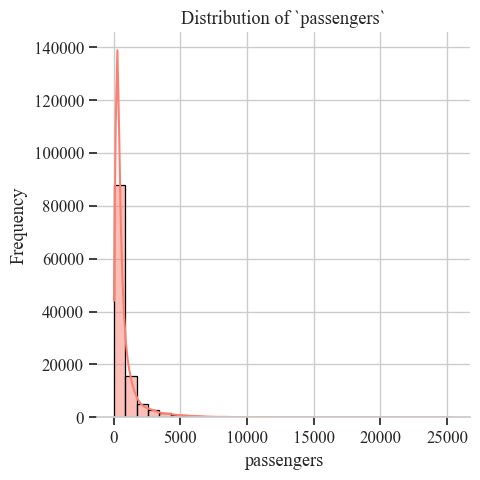

<Figure size 1000x500 with 0 Axes>

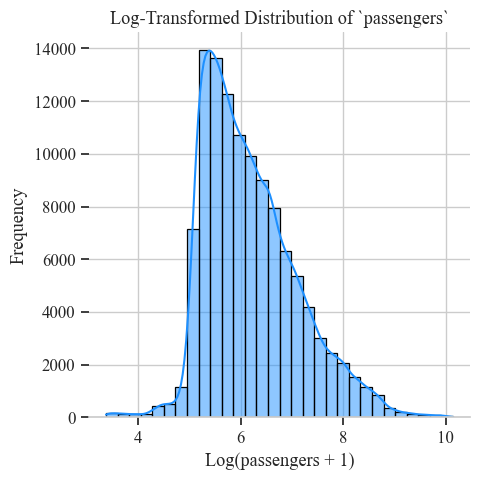

<Figure size 1000x500 with 0 Axes>

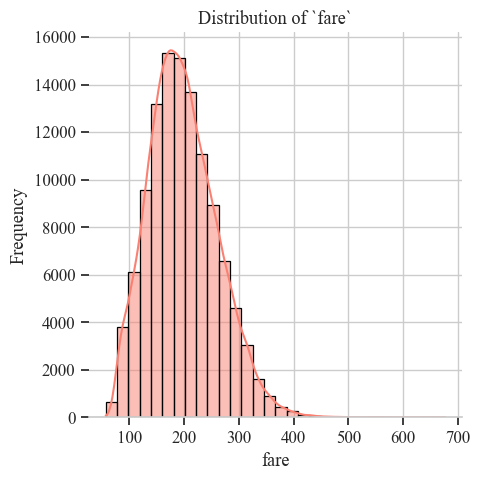

<Figure size 1000x500 with 0 Axes>

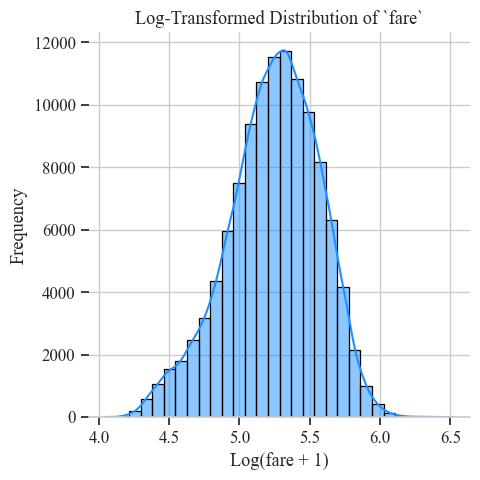

<Figure size 1000x500 with 0 Axes>

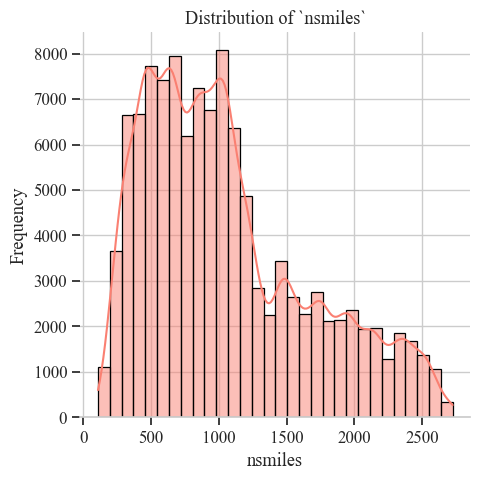

<Figure size 1000x500 with 0 Axes>

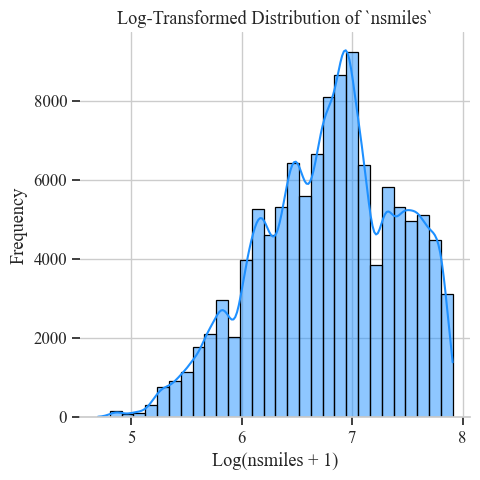

<Figure size 1000x500 with 0 Axes>

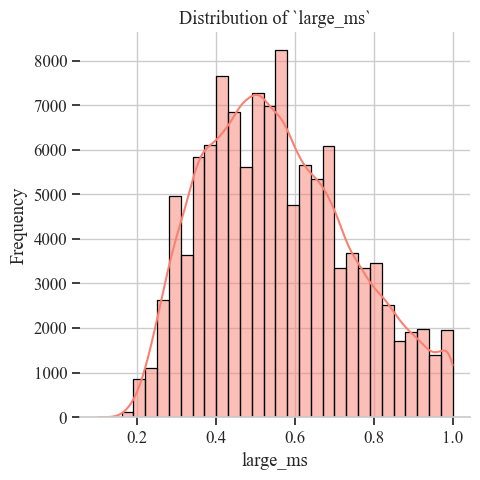

<Figure size 1000x500 with 0 Axes>

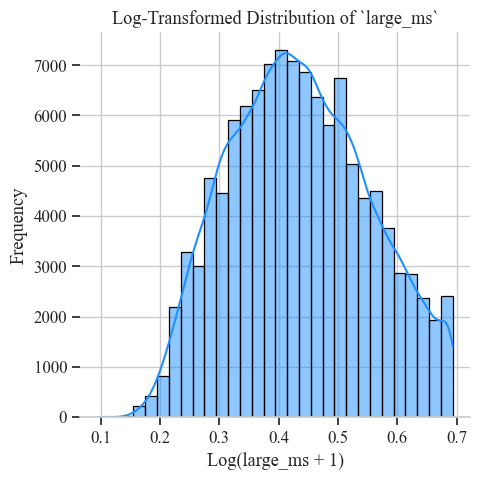

<Figure size 1000x500 with 0 Axes>

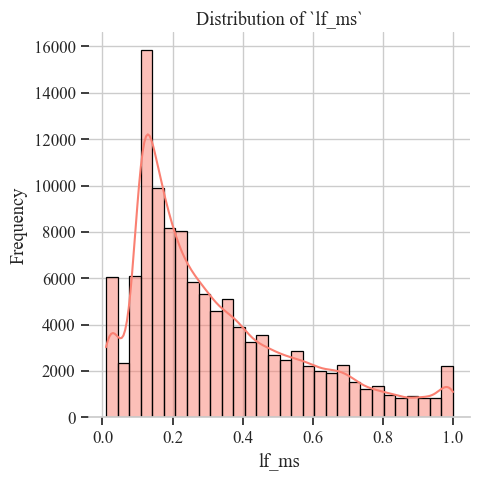

<Figure size 1000x500 with 0 Axes>

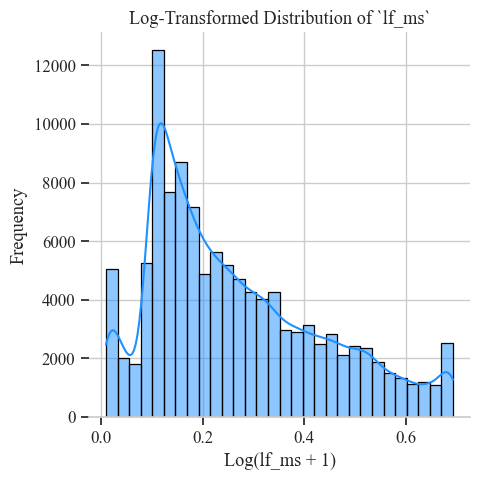

<Figure size 1000x500 with 0 Axes>

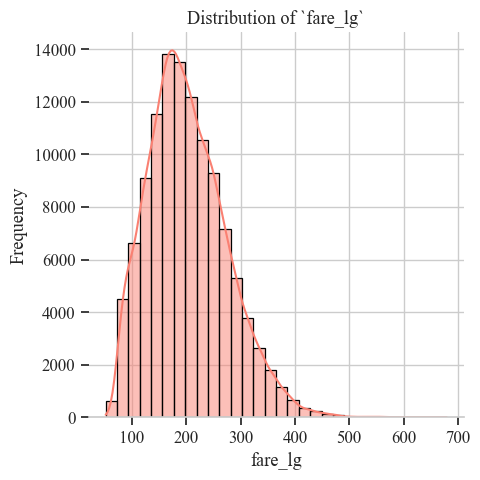

<Figure size 1000x500 with 0 Axes>

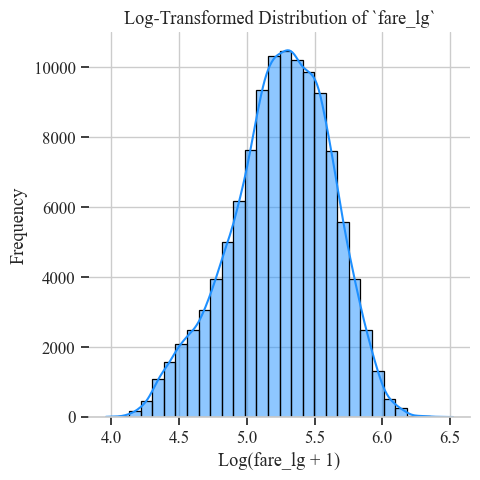

<Figure size 1000x500 with 0 Axes>

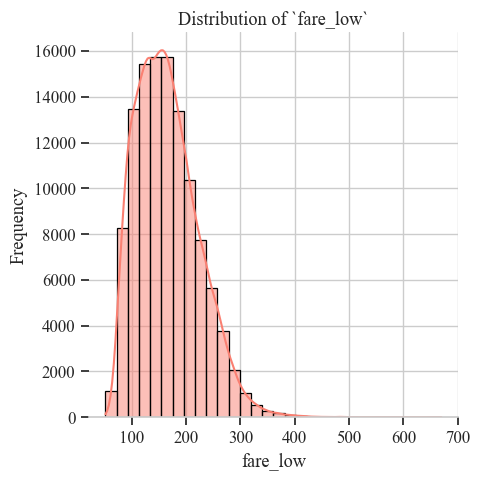

<Figure size 1000x500 with 0 Axes>

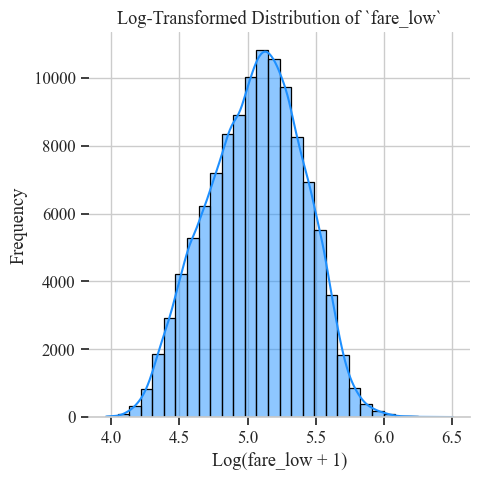

<Figure size 1000x500 with 0 Axes>

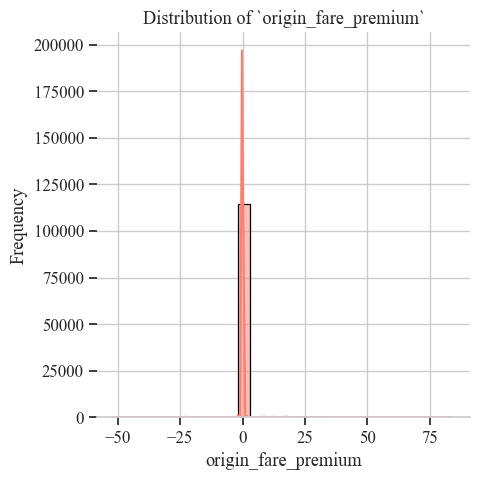

<Figure size 1000x500 with 0 Axes>

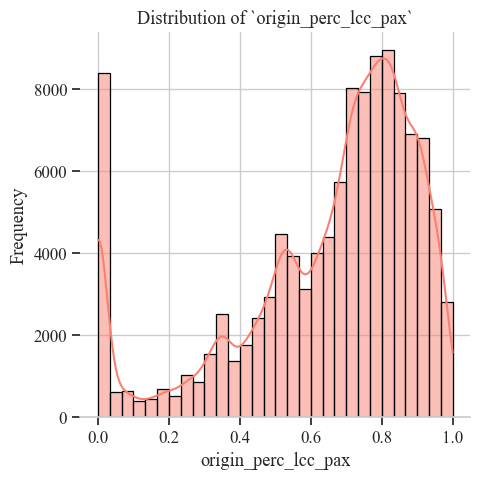

<Figure size 1000x500 with 0 Axes>

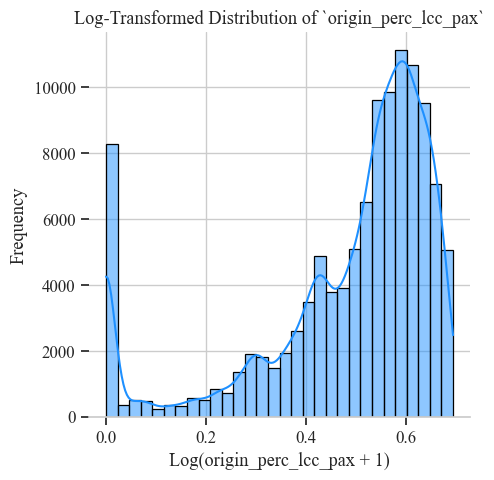

<Figure size 1000x500 with 0 Axes>

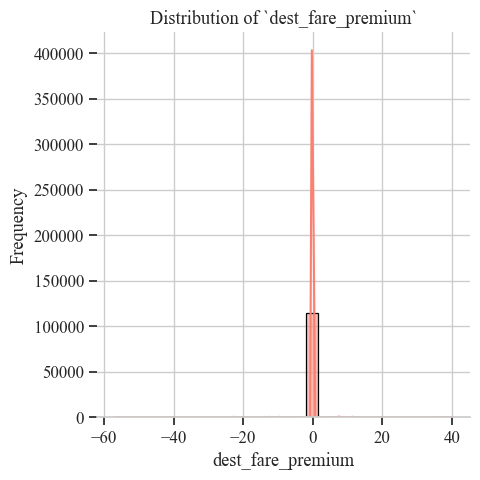

<Figure size 1000x500 with 0 Axes>

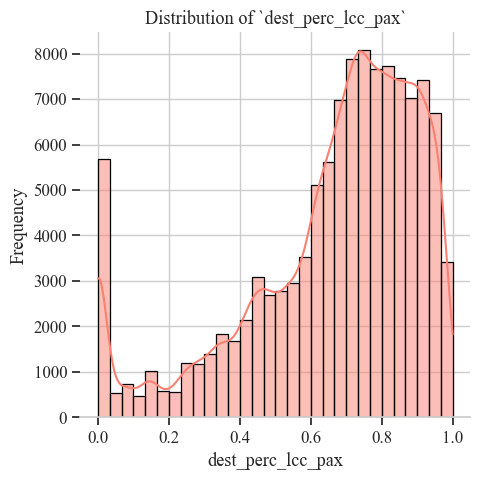

<Figure size 1000x500 with 0 Axes>

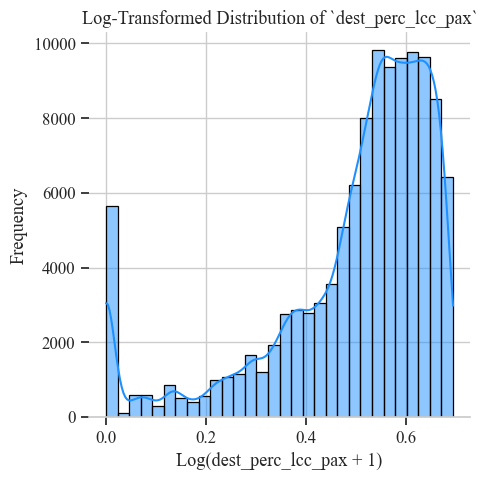


--- Generating Boxplots for Visual Outlier Review ---


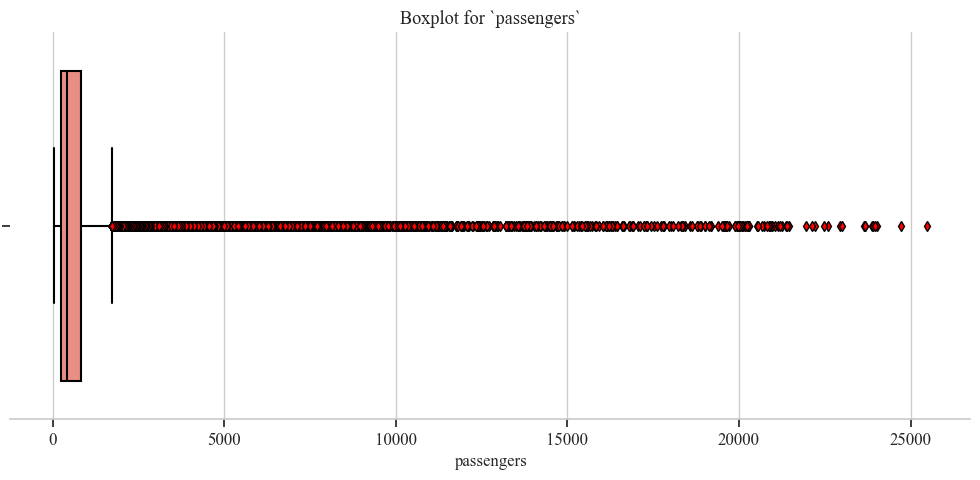

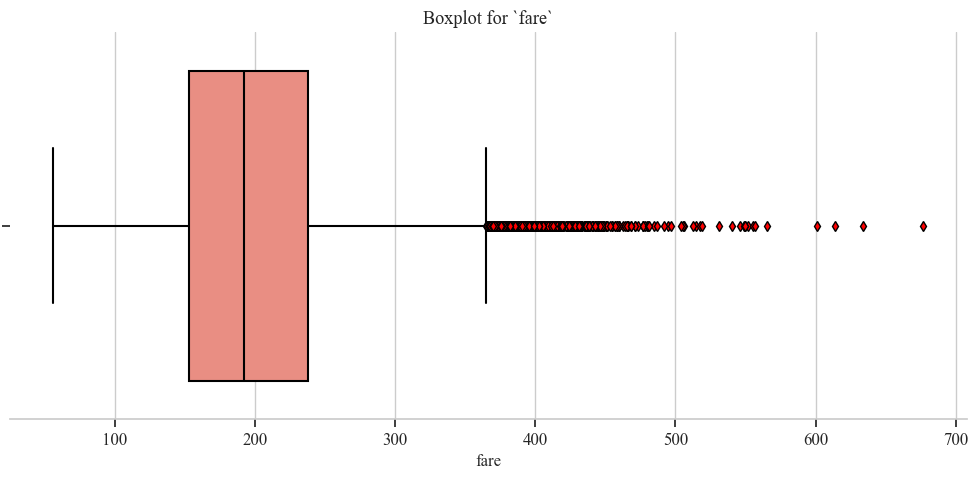

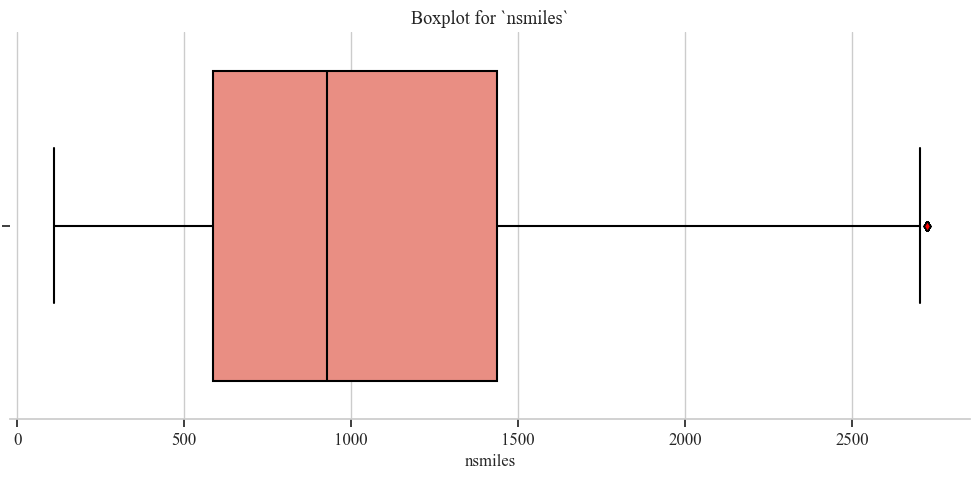

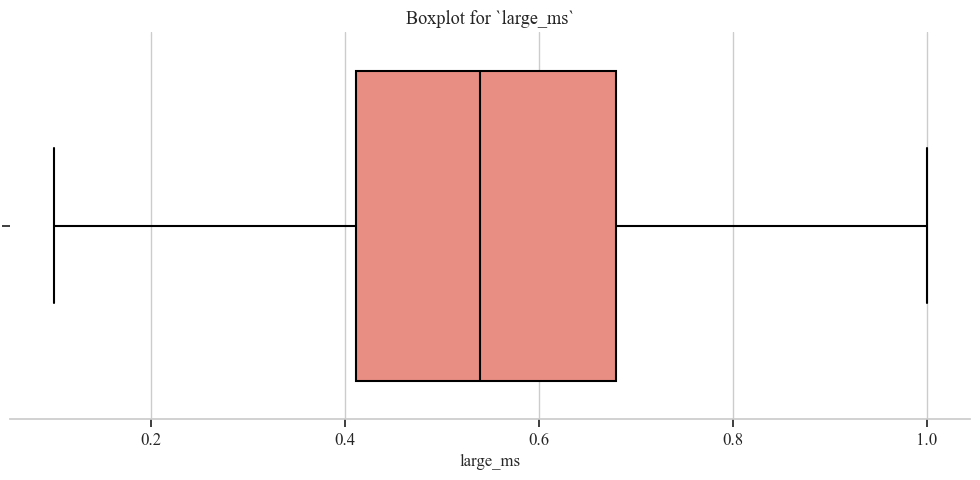

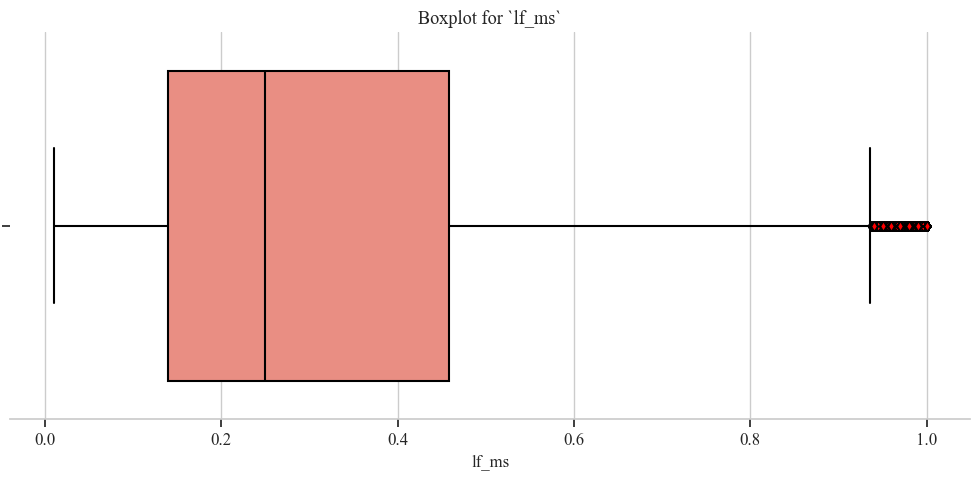

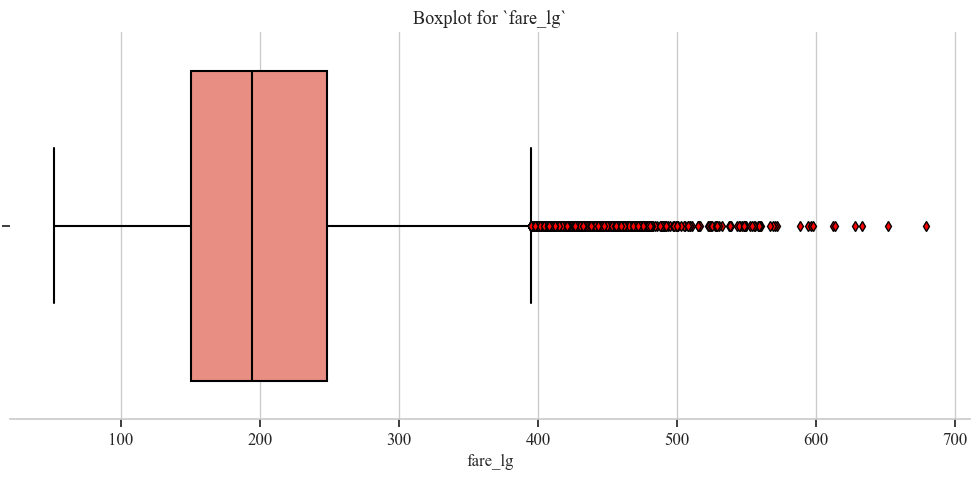

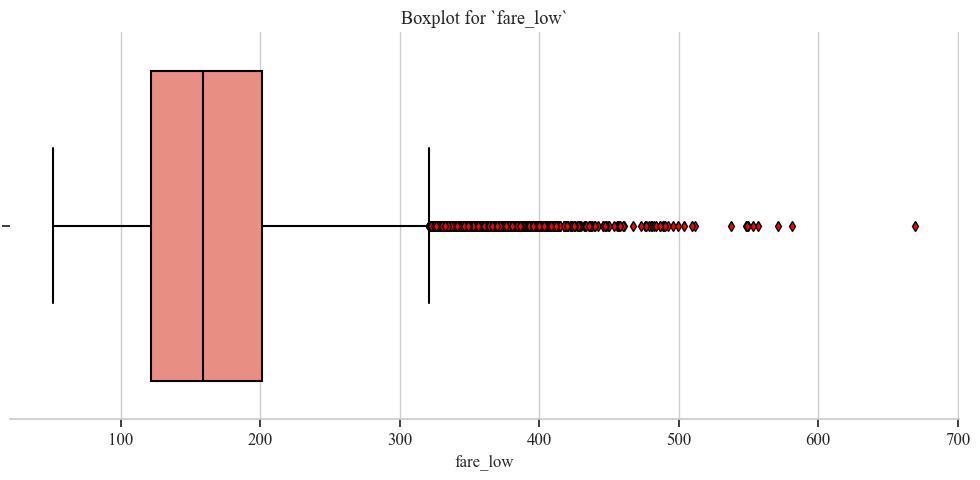

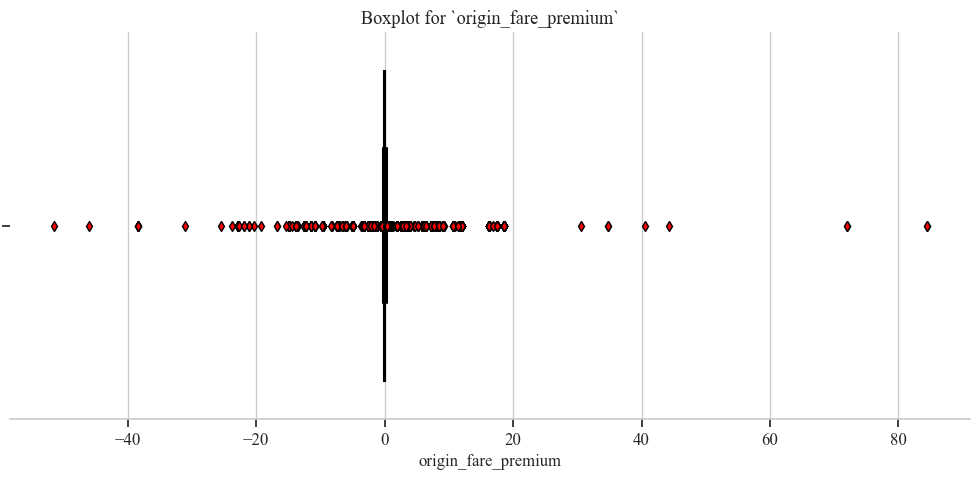

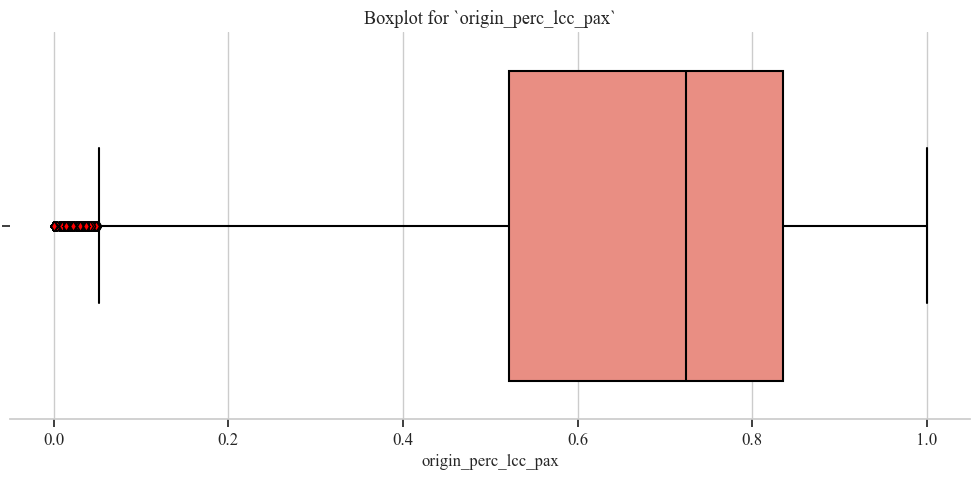

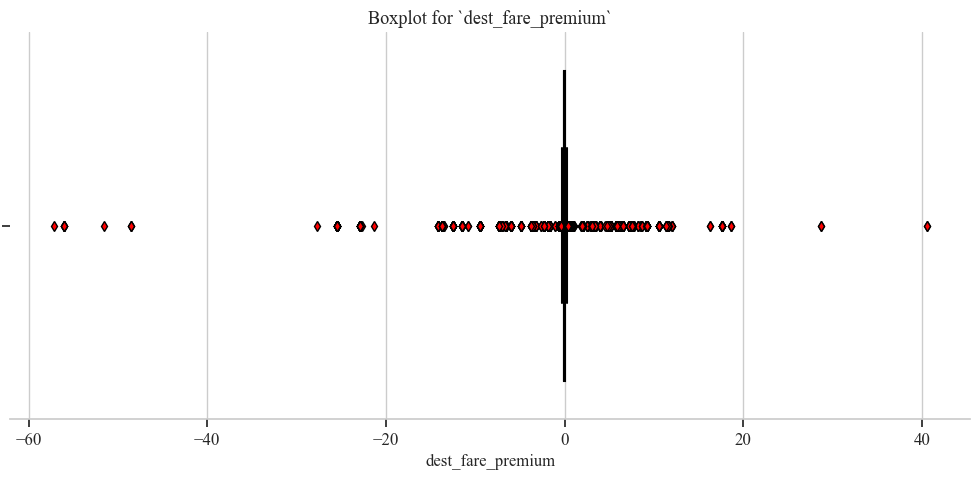

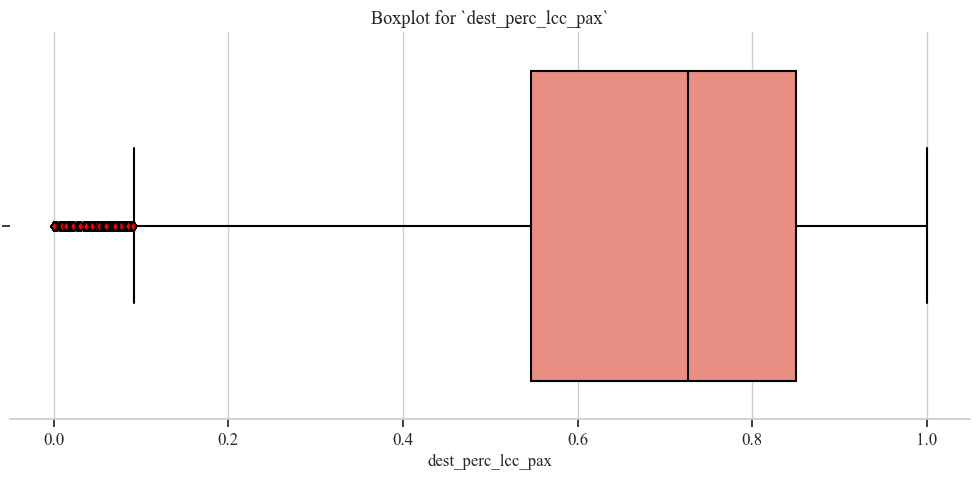

In [6]:
# --- Select Key Numerical Columns for Univariate Analysis ---
key_numeric_cols = [
    'passengers', 'fare', 'nsmiles', 'large_ms', 
    'lf_ms', 'fare_lg', 'fare_low',
    'origin_fare_premium', 'origin_perc_lcc_pax', 
    'dest_fare_premium', 'dest_perc_lcc_pax'
]
key_numeric_cols = [col for col in key_numeric_cols if col in df.columns]

# --- Generate Plots ---
plot_dist(df, key_numeric_cols)
plot_outliers(df, key_numeric_cols)

### 2.2. Outlier Detection (using IQR) & Strategy Discussion


In [7]:
print("\n--- Outlier Detection using IQR (Focused on Fare & Passengers) ---")
outlier_investigation_cols = ['fare', 'passengers']
for col in outlier_investigation_cols:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\nOutliers detected in '{col}' using IQR method: {len(outliers_iqr)} rows ({len(outliers_iqr)/len(df)*100:.2f}%)")
        print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

        # Investigate these outliers. Are they errors or extremes?
        if len(outliers_iqr) > 0 and len(outliers_iqr) < 50: # show sample if not too many
            print(f"Sample of outliers for {col}:")
            print(outliers_iqr[['nsmiles', 'lf_ms', 'fare_lg', 'fare_low', col]].head())

    else:
        print(f"Skipping IQR for '{col}': Not numeric or not found.")


--- Outlier Detection using IQR (Focused on Fare & Passengers) ---

Outliers detected in 'fare' using IQR method: 971 rows (0.84%)
Lower bound: 26.13, Upper bound: 365.17

Outliers detected in 'passengers' using IQR method: 11678 rows (10.15%)
Lower bound: -652.00, Upper bound: 1724.00


## **Section 3: Bivariate & Multivariate Analysis**

### 3.1. Treatment (Fare) & Outcome (Passengers)


--- Analyzing Fare vs. Passengers ---


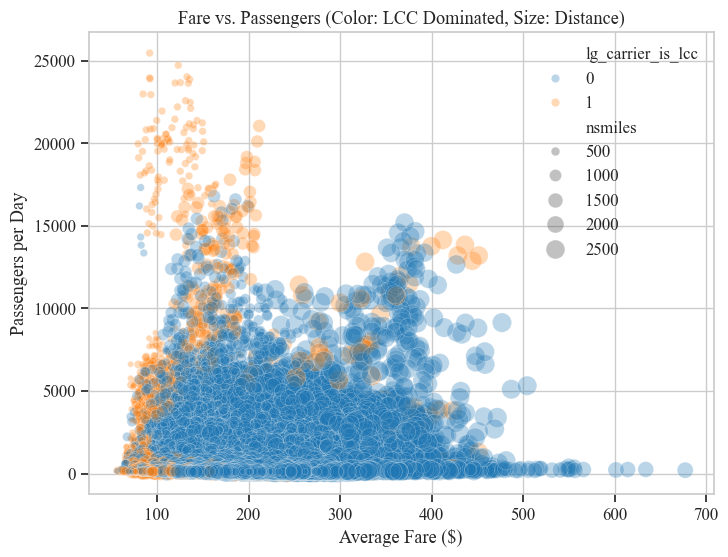

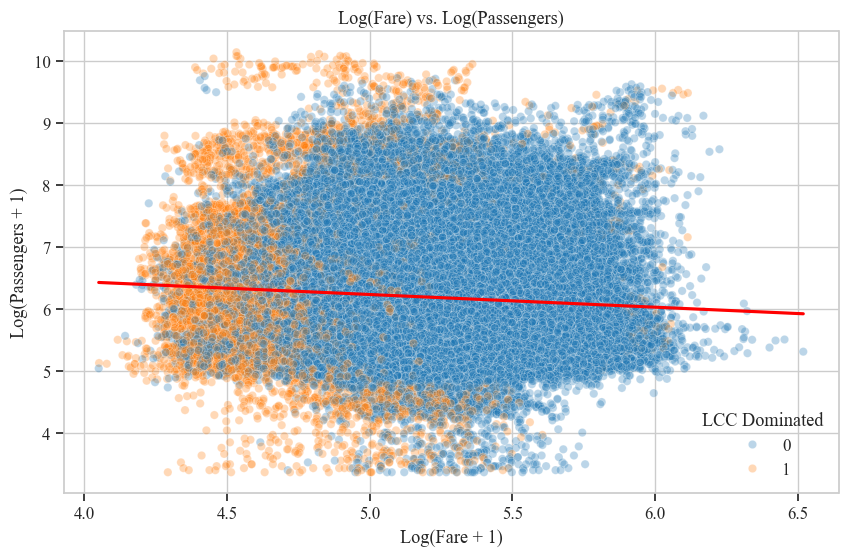

In [8]:
print("\n--- Analyzing Fare vs. Passengers ---")
plt.figure(figsize=(10, 6))
hue_col = 'lg_carrier_is_lcc' if 'lg_carrier_is_lcc' in df.columns else None

df['nsmiles'] = df['nsmiles'].astype(float)

sns.scatterplot(data=df, x='fare', y='passengers', alpha=0.3, hue=hue_col, size='nsmiles', sizes=(10, 200))
size_title = "Distance (nsmiles)"

plt.title('Fare vs. Passengers (Color: LCC Dominated, Size: Distance)')
plt.xlabel('Average Fare ($)'); plt.ylabel('Passengers per Day'); plt.grid(True)
if hue_col and size_title:
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.subplots_adjust(right=0.75) 
elif hue_col:
    plt.legend(title='LCC Dominated', loc='best')
elif size_title:
    plt.legend(title=size_title, loc='best')

plt.savefig(f'../outputs/EDA_fare-pax_LCC-dominated.png', dpi=300)     
plt.show()

# Log-log plot for elasticity hint
plt.figure(figsize=(10, 6))

# df_log = df.copy()
# df_log['fare'] = pd.to_numeric(df_log['fare'], errors='coerce')
# df_log['passengers'] = pd.to_numeric(df_log['passengers'], errors='coerce')

# df_log = df_log.dropna(subset=['fare', 'passengers'])
# df_log = df_log[(df_log['fare'] > 0) & (df_log['passengers'] > 0)].copy()

df_log = df[(df['fare'] > 0) & (df['passengers'] > 0)].copy() # non-negative before log - fare/passengers > 0

df_log['log_fare'] = np.log1p(df_log['fare'])
df_log['log_passengers'] = np.log1p(df_log['passengers'])

hue_col = 'lg_carrier_is_lcc'
if hue_col in df_log.columns: 
    hue_data = df_log[hue_col]
else:
    hue_data = None
    
sns.scatterplot(data=df_log, x='log_fare', y='log_passengers', alpha=0.3, hue=hue_data)
sns.regplot(data=df_log, x='log_fare', y='log_passengers', scatter=False, color='red', line_kws={'label':'Linear Trend (Log-Log)'})
plt.title('Log(Fare) vs. Log(Passengers)')
plt.xlabel('Log(Fare + 1)'); plt.ylabel('Log(Passengers + 1)')
if hue_col: plt.legend(title='LCC Dominated', loc='best')
plt.grid(True)
plt.savefig(f'../outputs/EDA_log_fare-pax_LCC-dominated.png', dpi=300)     
plt.show()

### 3.2. Treatment (Fare) vs. Key Confounders 

In [9]:
confounders_to_plot = ['nsmiles', 'large_ms', 'origin_fare_premium', 'dest_fare_premium', 
                       'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday']
confounders_to_plot = [c for c in confounders_to_plot if c in df.columns]


--- Analyzing Fare vs. Potential Confounders ---


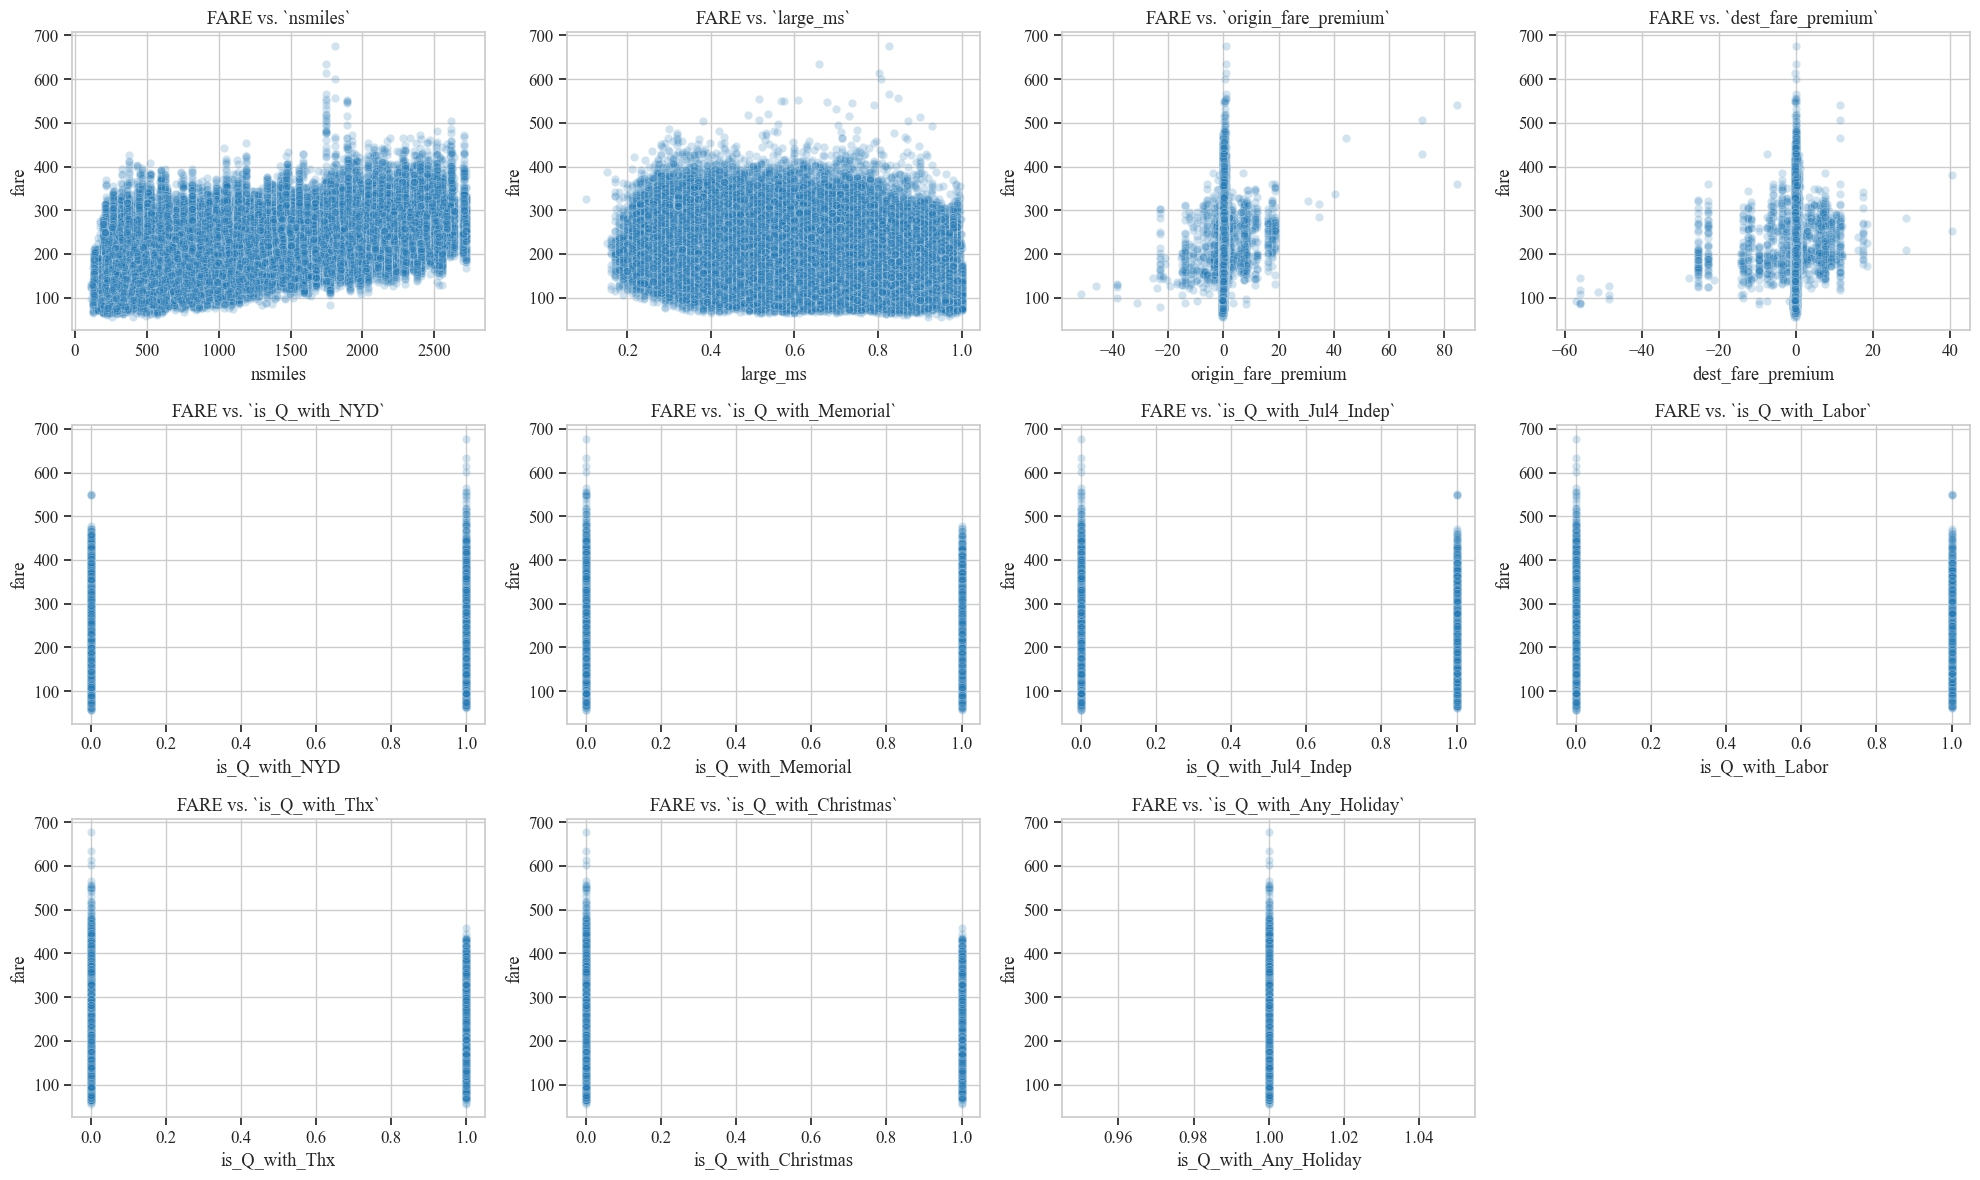

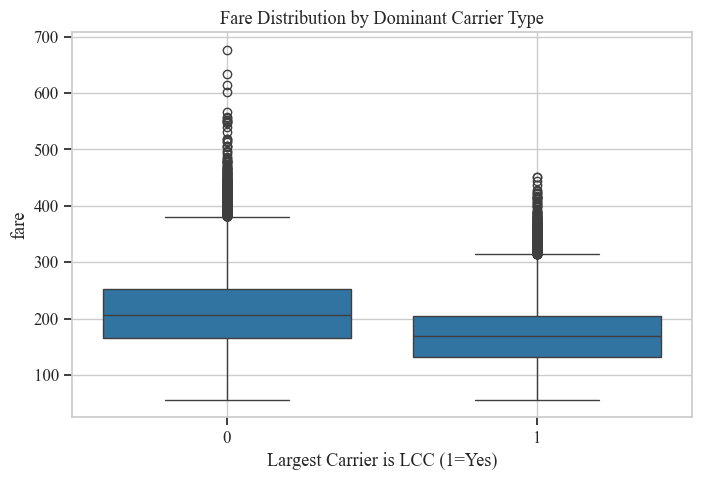

In [10]:
print("\n--- Analyzing Fare vs. Potential Confounders ---")
n_conf = len(confounders_to_plot)
if n_conf > 0:
    max_cols = 4
    ncols = min(n_conf, max_cols)
    nrows = (n_conf + ncols - 1) // ncols
    plt.figure(figsize=(ncols*5, nrows*4))
    for i, col in enumerate(confounders_to_plot):
        ax = plt.subplot(nrows, ncols, i + 1)
        sns.scatterplot(data=df, x=col, y='fare', alpha=0.2, ax=ax)
        ax.set_title(f'FARE vs. `{col}`')
        ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()

if 'lg_carrier_is_lcc' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='lg_carrier_is_lcc', y='fare')
    plt.title('Fare Distribution by Dominant Carrier Type')
    plt.xlabel('Largest Carrier is LCC (1=Yes)'); 
    plt.grid(True)
    plt.show()

### 3.3. Outcome (Passengers) vs. Key Confounders 


--- Analyzing Passengers vs. Potential Confounders ---


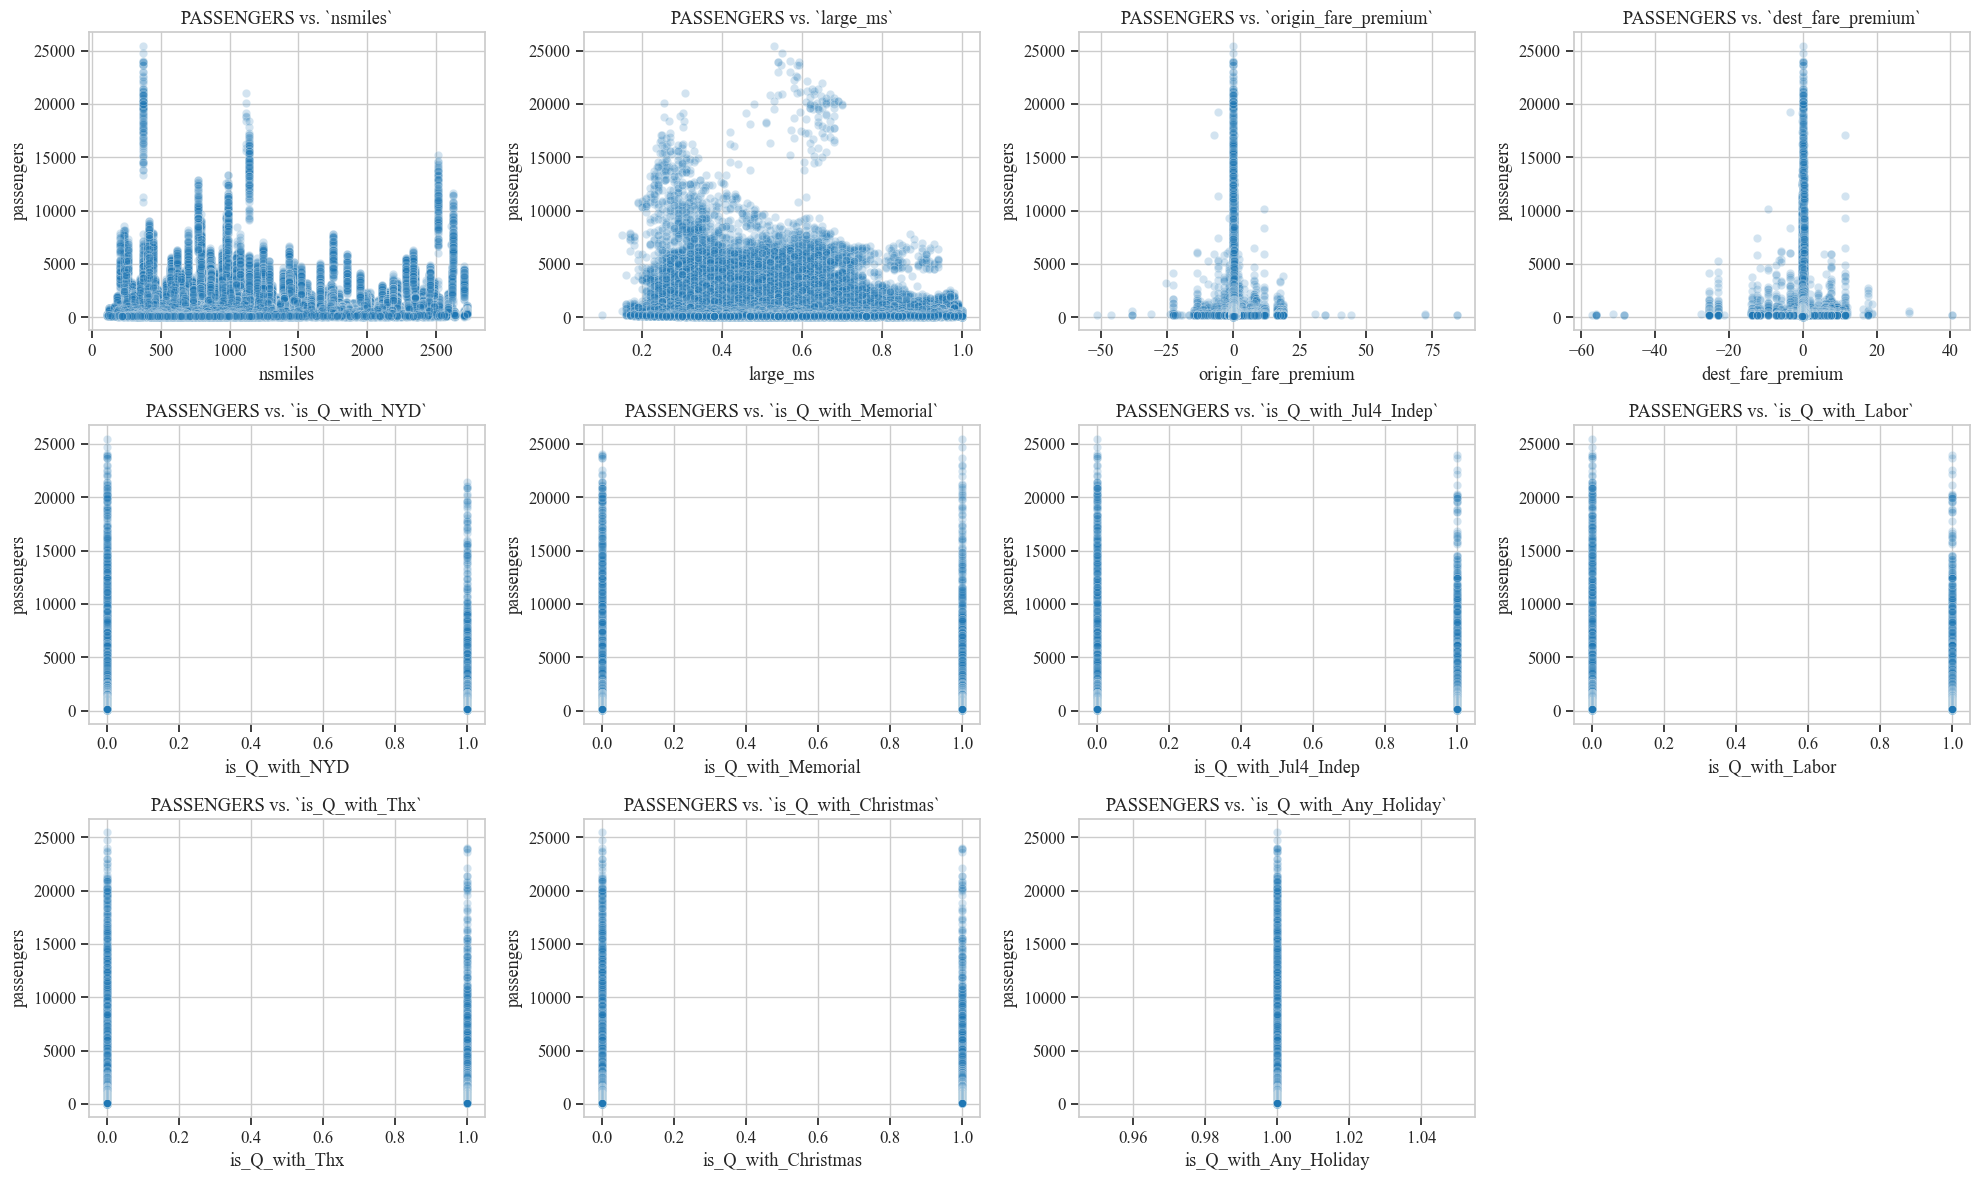

In [11]:
print("\n--- Analyzing Passengers vs. Potential Confounders ---")
if n_conf > 0:
    max_cols = 4
    ncols = min(n_conf, max_cols)
    nrows = (n_conf + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows*4)) 
    for i, col in enumerate(confounders_to_plot):
        ax = plt.subplot(nrows, ncols, i + 1)
        sns.scatterplot(data=df, x=col, y='passengers', alpha=0.2, ax=ax)
        ax.set_title(f'PASSENGERS vs. `{col}`')
        ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()

### 3.4. Explore Passengers & Fares vs. Holiday Confounders 

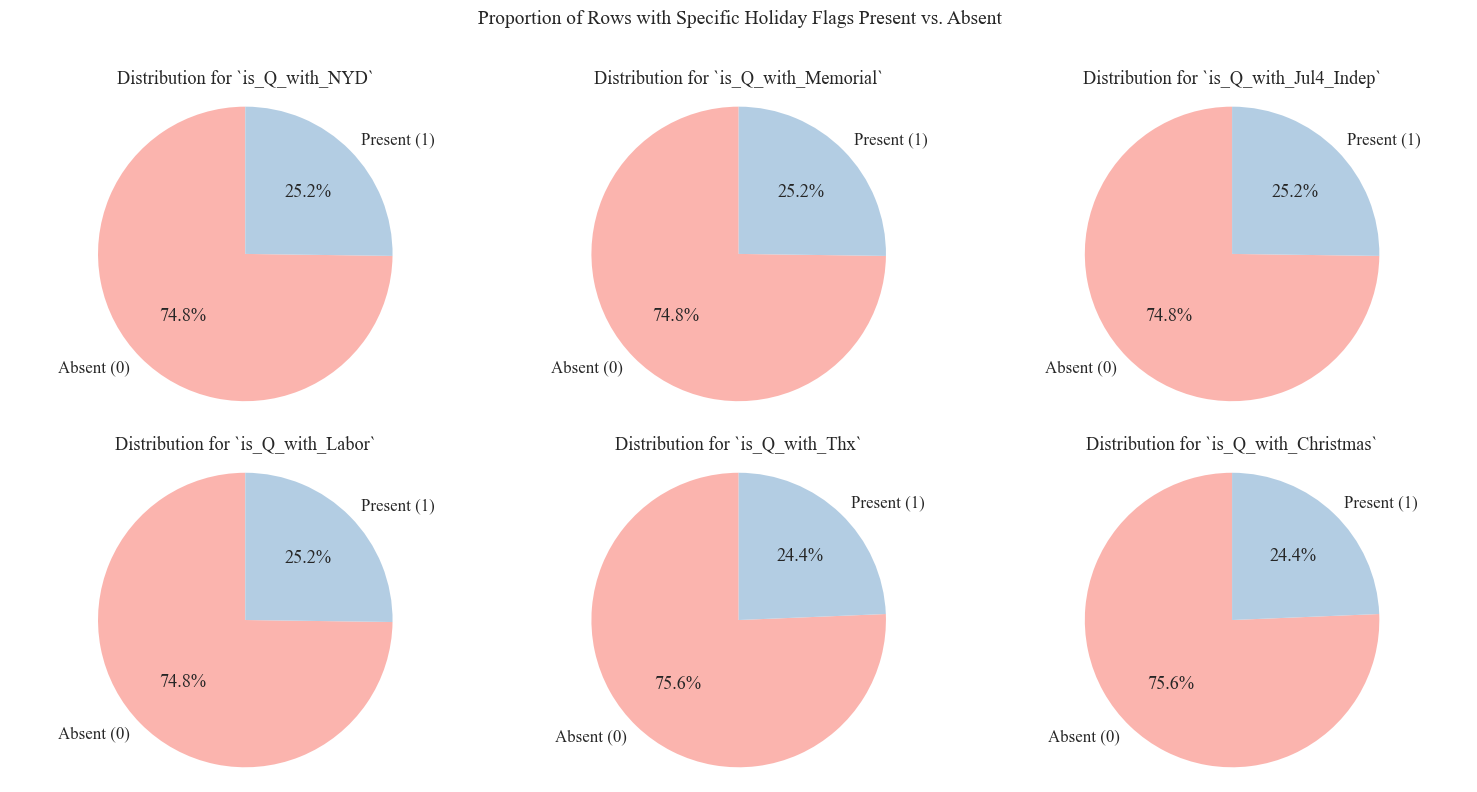

In [12]:
holiday_confounders = ['is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas']
n_conf = len(holiday_confounders)

if n_conf > 0:
    max_cols = 3
    ncols = min(n_conf, max_cols)
    nrows = (n_conf + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows*4)) 
    for i, conf in enumerate(holiday_confounders):
        ax = plt.subplot(nrows, ncols, i + 1)
        counts = df[conf].value_counts().sort_index()
        labels = ['Absent (0)', 'Present (1)']
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors) 
        ax.set_title(f'Distribution for `{conf}`')
        ax.axis('equal') 
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
    plt.suptitle("Proportion of Rows with Specific Holiday Flags Present vs. Absent", fontsize=14, y=1.02) 
    plt.show()

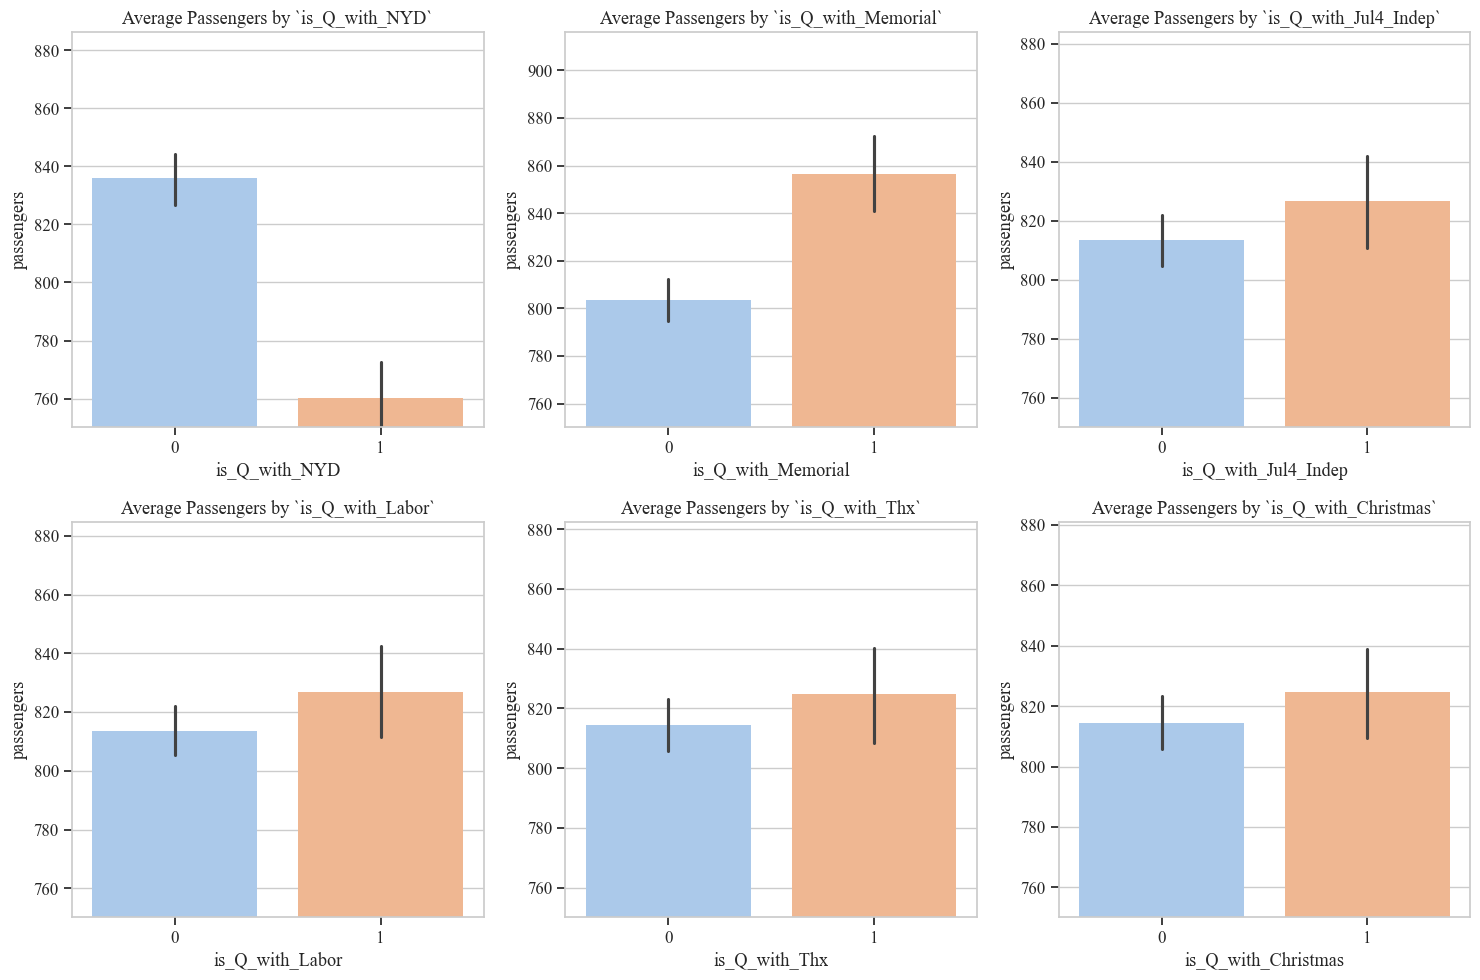

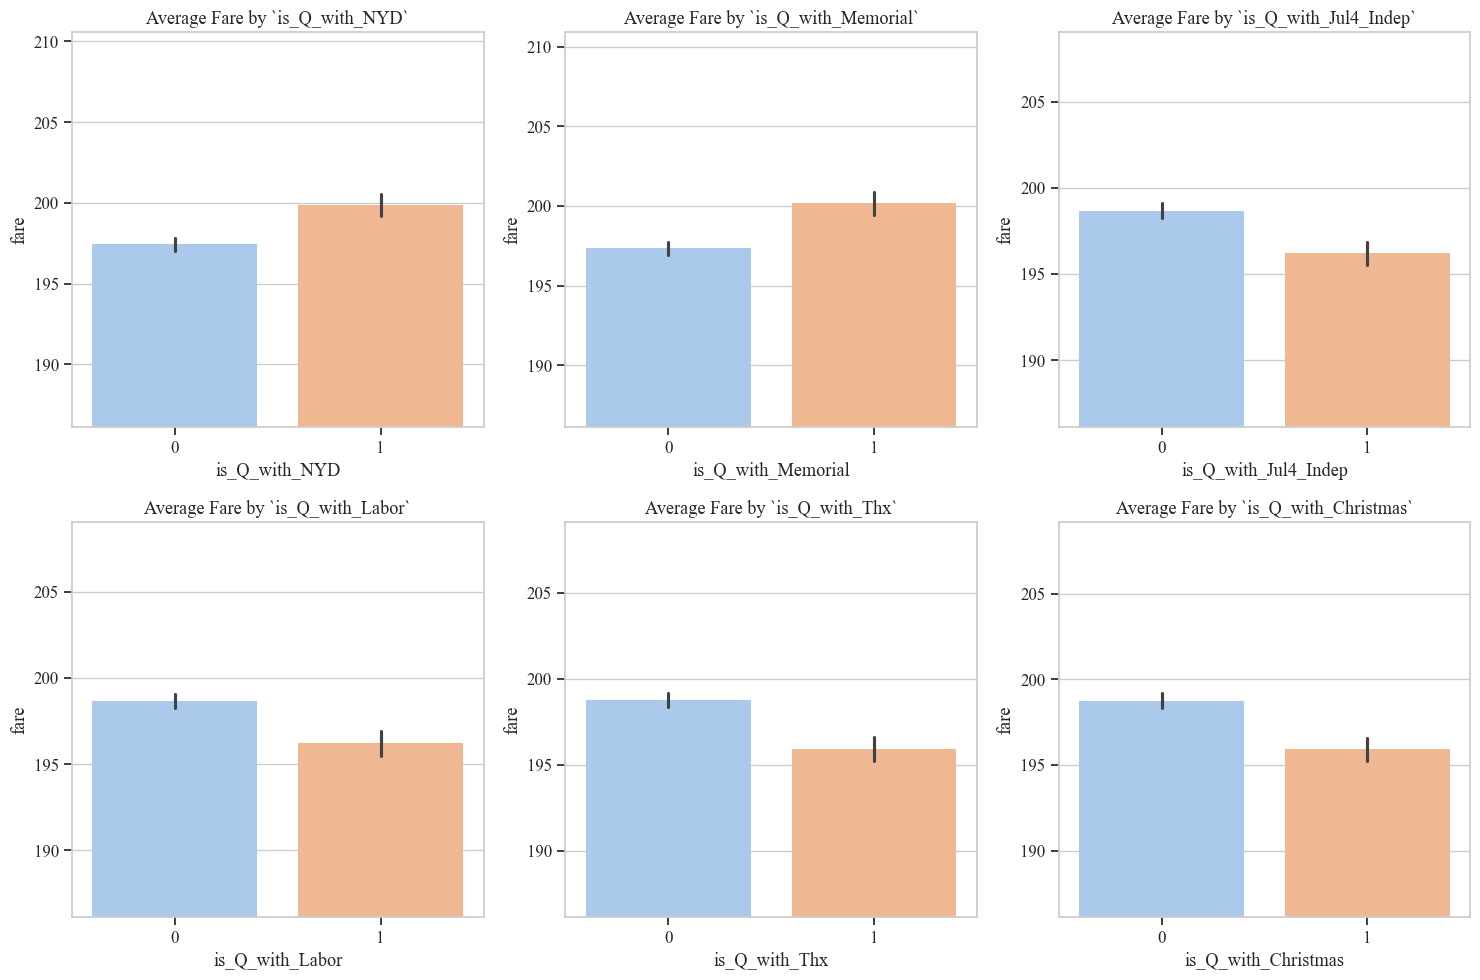

In [13]:
if n_conf > 0:
    max_cols = 3
    ncols = min(n_conf, max_cols)
    nrows = (n_conf + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows * 5)) 
    # Calculate the overall minimum average passenger count
    min_avg_pax = df.groupby(holiday_confounders)['passengers'].mean().min()
    # Define a new y-axis min with a small buffer
    y_min_pax = max(0, min_avg_pax - 10) # ensure non-negative
    for i, conf in enumerate(holiday_confounders):
        ax = plt.subplot(nrows, ncols, i + 1)
        sns.barplot(data=df, x=conf, y='passengers', palette='pastel', hue=conf, legend=False, ax=ax)
        ax.set_title(f'Average Passengers by `{conf}`')
        ax.set_xlabel(conf)
        # Apply the new y-axis limit
        ax.set_ylim(bottom=y_min_pax) # Let matplotlib determine the top
    plt.tight_layout()
    plt.savefig(f'../outputs/EDA_avg_pax_in_holidays.png', dpi=300)
    plt.show()
    
if n_conf > 0:
    max_cols = 3
    ncols = min(n_conf, max_cols)
    nrows = (n_conf + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows * 5)) 
    # Calculate the overall minimum average fare
    min_avg_fare = df.groupby(holiday_confounders)['fare'].mean().min()
    # Define a new y-axis minimum with a small buffer
    y_min_fare = max(0, min_avg_fare * 0.95) # using 95% of the minimum as a buffer, ensuring it's not negative
    for i, conf in enumerate(holiday_confounders):
        ax = plt.subplot(nrows, ncols, i + 1)
        sns.barplot(data=df, x=conf, y='fare', palette='pastel', hue=conf, legend=False, ax=ax)
        ax.set_title(f'Average Fare by `{conf}`')
        ax.set_xlabel(conf)
        ax.set_ylim(bottom=y_min_fare)
    plt.tight_layout()
    plt.savefig(f'../outputs/EDA_avg_fare_in_holidays.png', dpi=300)
    plt.show()

## **Section 4 - Correlation Analysis**

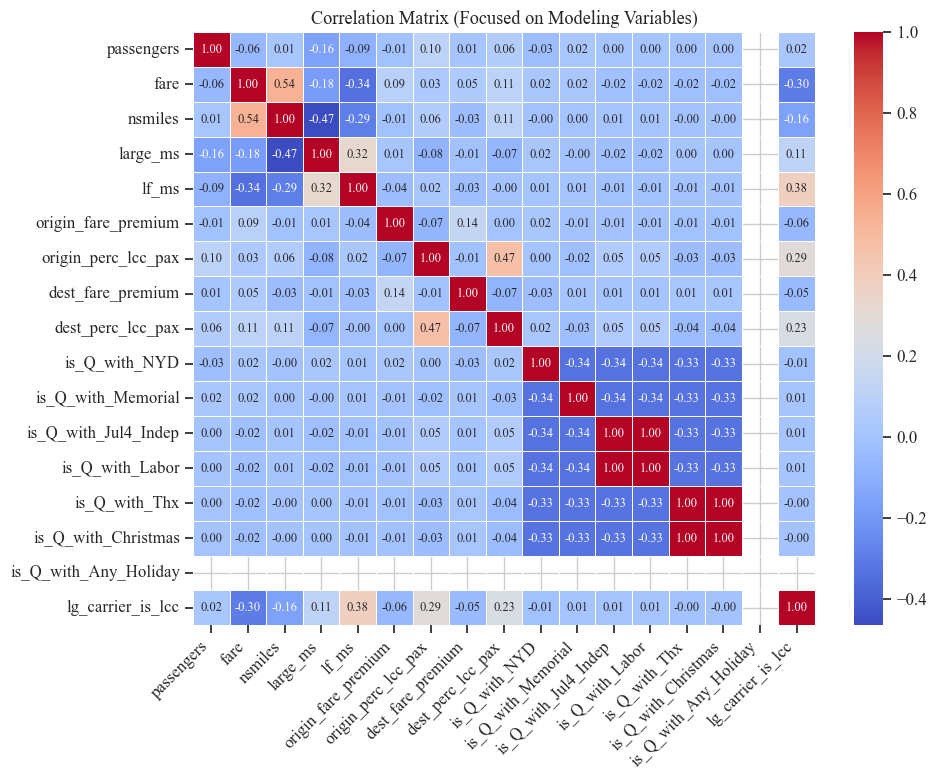

In [14]:
cols_for_corr_focused = [
    'passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms',
    'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax',
    'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday'
]
if 'lg_carrier_is_lcc' in df.columns: 
    cols_for_corr_focused.append('lg_carrier_is_lcc')
cols_for_corr_focused = [col for col in cols_for_corr_focused if col in df.columns]

# Convert Int64 to numeric that .corr() understands 
correlation_matrix_focused = df[cols_for_corr_focused].astype(float).corr() 

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_focused, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 9})
plt.title('Correlation Matrix (Focused on Modeling Variables)')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'../outputs/EDA_correlation_matrix.png', dpi=300)
plt.show()
# Check for multicollinearity between confounders/predictors

## **Section 5 - Time Series Analysis**

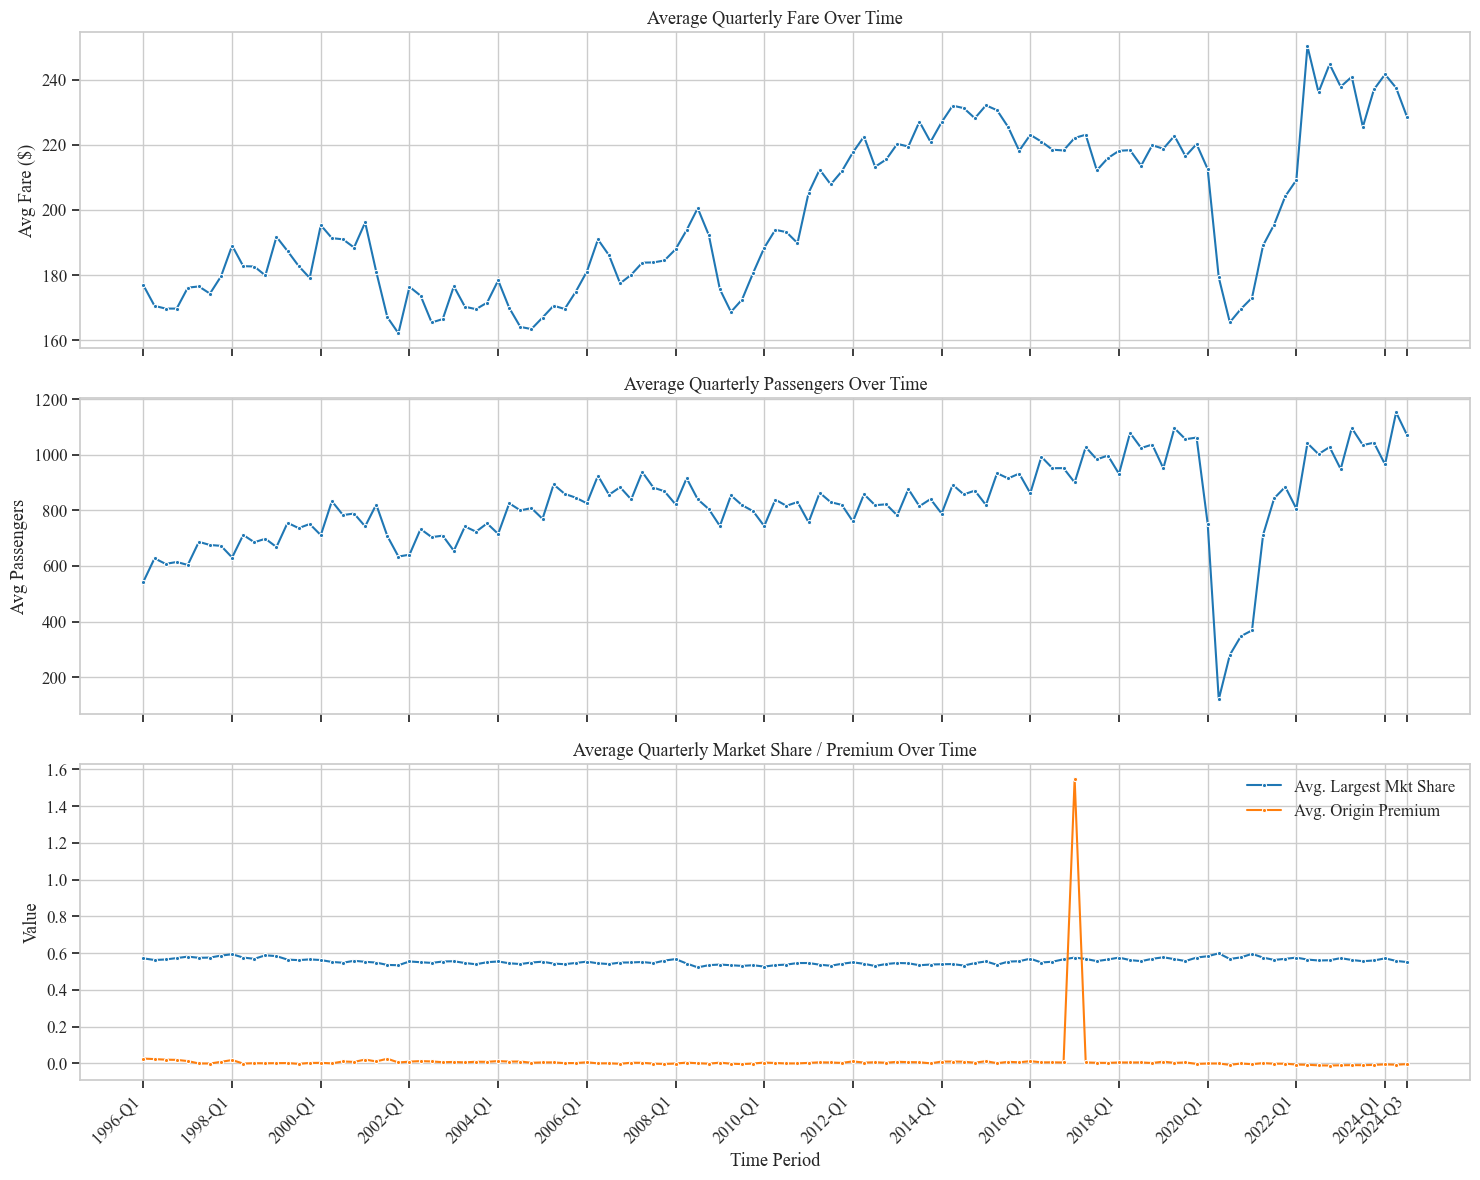

In [15]:

cols_to_agg = ['fare', 'passengers', 'large_ms', 'origin_fare_premium']
cols_to_agg = [c for c in cols_to_agg if c in df.columns] 
numeric_agg_cols = [c for c in cols_to_agg if pd.api.types.is_numeric_dtype(df[c])]

df_time_agg = df.groupby('period')[numeric_agg_cols].mean().reset_index()
df_time_agg = df_time_agg.sort_values(by=['period']) # ensure sorted by period string

# Create subplots sharing the x-axis
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True) # keep sharex=True

# Plot data on respective axes
sns.lineplot(data=df_time_agg, x='period', y='fare', marker='.', ax=axes[0])
axes[0].set_title('Average Quarterly Fare Over Time')
axes[0].grid(True); axes[0].set_ylabel('Avg Fare ($)'); axes[0].set_xlabel('') # no x-label on upper plots

sns.lineplot(data=df_time_agg, x='period', y='passengers', marker='.', ax=axes[1])
axes[1].set_title('Average Quarterly Passengers Over Time')
axes[1].grid(True); axes[1].set_ylabel('Avg Passengers'); axes[1].set_xlabel('') # no x-label on upper plots

plot_third = False # flag to check if third plot is drawn
if 'large_ms' in df_time_agg.columns and 'origin_fare_premium' in df_time_agg.columns:
    sns.lineplot(data=df_time_agg, x='period', y='large_ms', marker='.', label='Avg. Largest Mkt Share', ax=axes[2])
    sns.lineplot(data=df_time_agg, x='period', y='origin_fare_premium', marker='.', label='Avg. Origin Premium', ax=axes[2])
    axes[2].set_title('Average Quarterly Market Share / Premium Over Time')
    axes[2].grid(True); axes[2].legend(); axes[2].set_ylabel('Value'); axes[2].set_xlabel('Time Period') # set x label only on bottom
    plot_third = True
else:
    axes[1].set_xlabel('Time Period') # set x label only on bottom if 3rd plot unused
    fig.delaxes(axes[2]) 

# SET SPARSE X-Tick Labels (Visible on ALL axes due to sharex=True) 
# 1. Get all period labels
all_periods = df_time_agg['period'].tolist()
num_periods = len(all_periods)

# 2. Determine tick frequency (e.g., every 8 quarters = 2 years)
tick_step = 8 # Adjust as needed for non-overlap
if num_periods / tick_step > 20: tick_step = 12
elif num_periods / tick_step > 15: tick_step = 8

tick_indices = np.arange(0, num_periods, tick_step)
if num_periods - 1 not in tick_indices and num_periods - 1 - tick_indices[-1] < tick_step / 2:
        tick_indices = np.append(tick_indices, num_periods - 1)
tick_labels = [all_periods[i] for i in tick_indices]

# 3. Apply ticks and labels, since sharex=True, setting it for one sets it for all
bottom_ax = axes[2] if plot_third else axes[1]
bottom_ax.set_xticks(tick_indices)
bottom_ax.set_xticklabels(tick_labels, rotation=45, ha='right')

plt.tight_layout() 
plt.show()


## **Section 6 - Categorical Analysis**

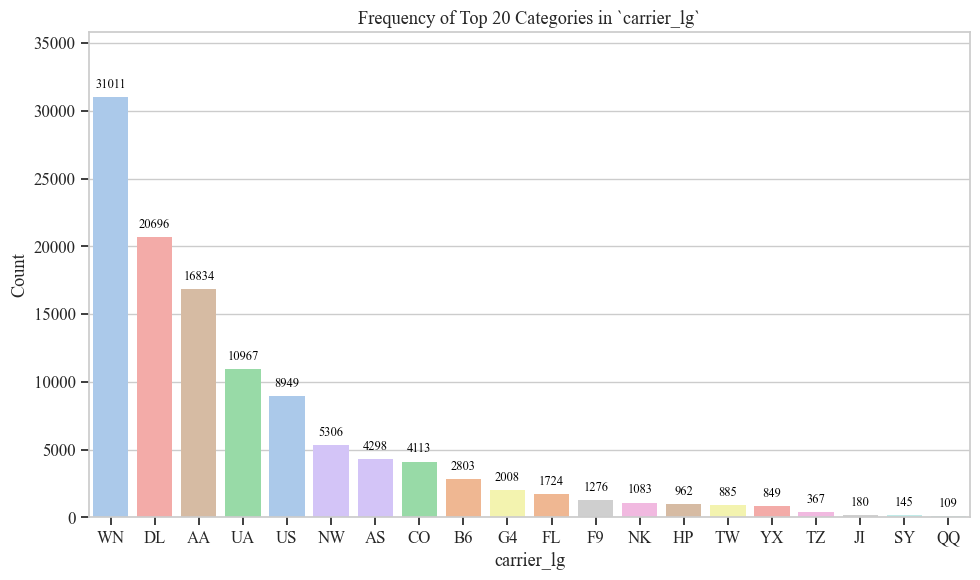

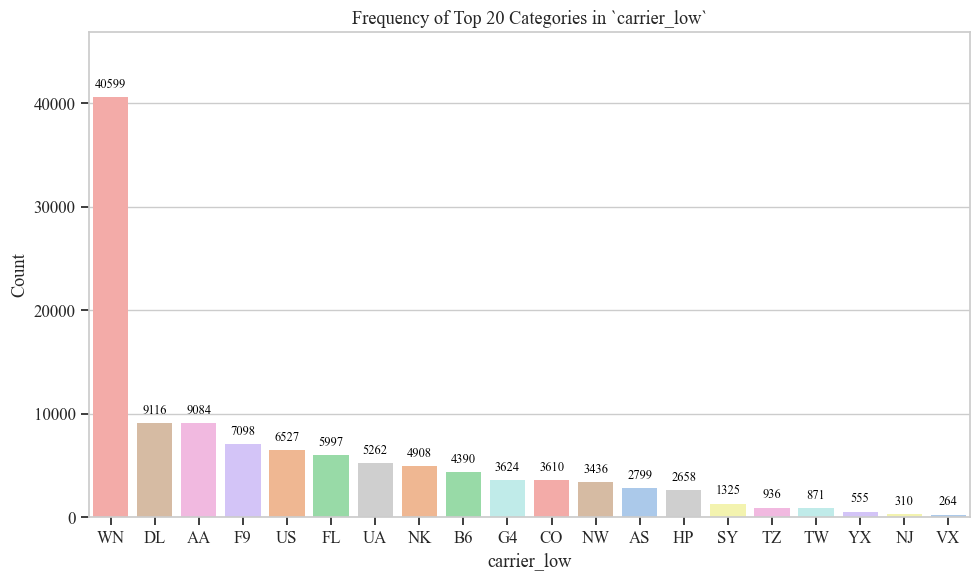

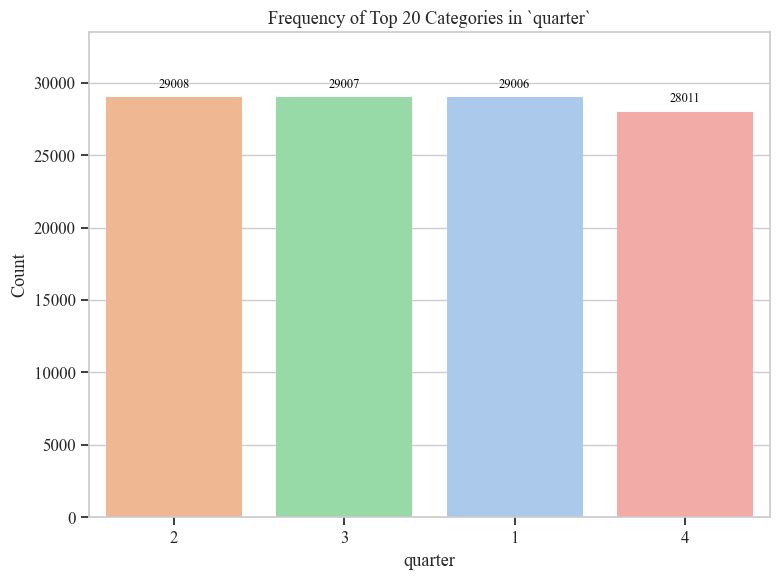

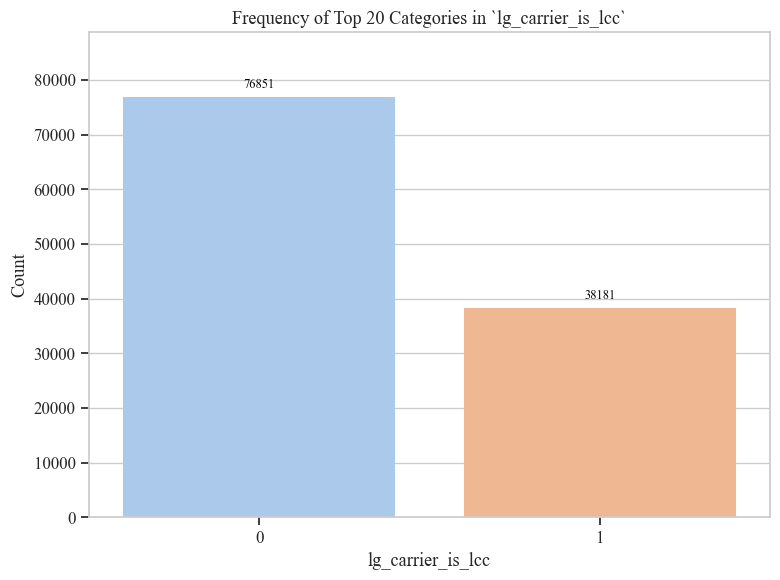

In [16]:
cat_cols_to_analyze = ['carrier_lg', 'carrier_low', 'quarter'] 
cat_cols_to_analyze.append('lg_carrier_is_lcc')

for col in cat_cols_to_analyze:
    top_n = 20 # limit to top N categories for better readability 
    col_dtype = df[col].dtype
    col_nunique = df[col].nunique()

    # Proceed if object or if numeric with few unique values (like quarter or LCC flag)
    if pd.api.types.is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype) or col_nunique <= top_n * 2:
        # Prepare data and order
        value_counts = df[col].value_counts()
        order = value_counts.index[:top_n]
        
        # Filter data to include only the top N categories for plotting
        plot_data = df[df[col].isin(order)]
        
        fig_width = max(8, len(order) * 0.5) 
        plt.figure(figsize=(fig_width, 6)) 

        # Create vertical column plot (using countplot with x=)
        ax = sns.countplot(data=plot_data, x=col, order=order, palette='pastel', hue=col, legend=False)

        # Add data labels to each bar
        for p in ax.patches:
            ax.annotate(
                f'{int(p.get_height())}',         
                (p.get_x() + p.get_width() / 2., p.get_height()), # position: (center_x, bar_top)
                ha = 'center',                                    # horizontal alignment
                va = 'center',                                    # vertical alignment
                size=9,                                           # font size for label
                xytext = (0, 9),                                  # offset: (x=0, y=9 points)
                textcoords = 'offset points',                     # use points for offset
                color='black'                 
            )

        plt.title(f'Frequency of Top {top_n} Categories in `{col}`')
        plt.ylabel('Count')
        plt.xlabel(col)     
        ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
        plt.tight_layout() 
        plt.show()
    else:
        print(f"Skipping countplot for '{col}': Not categorical or too many unique values ({col_nunique}).")

## **Section 7 - Heterogeneity Exploration**

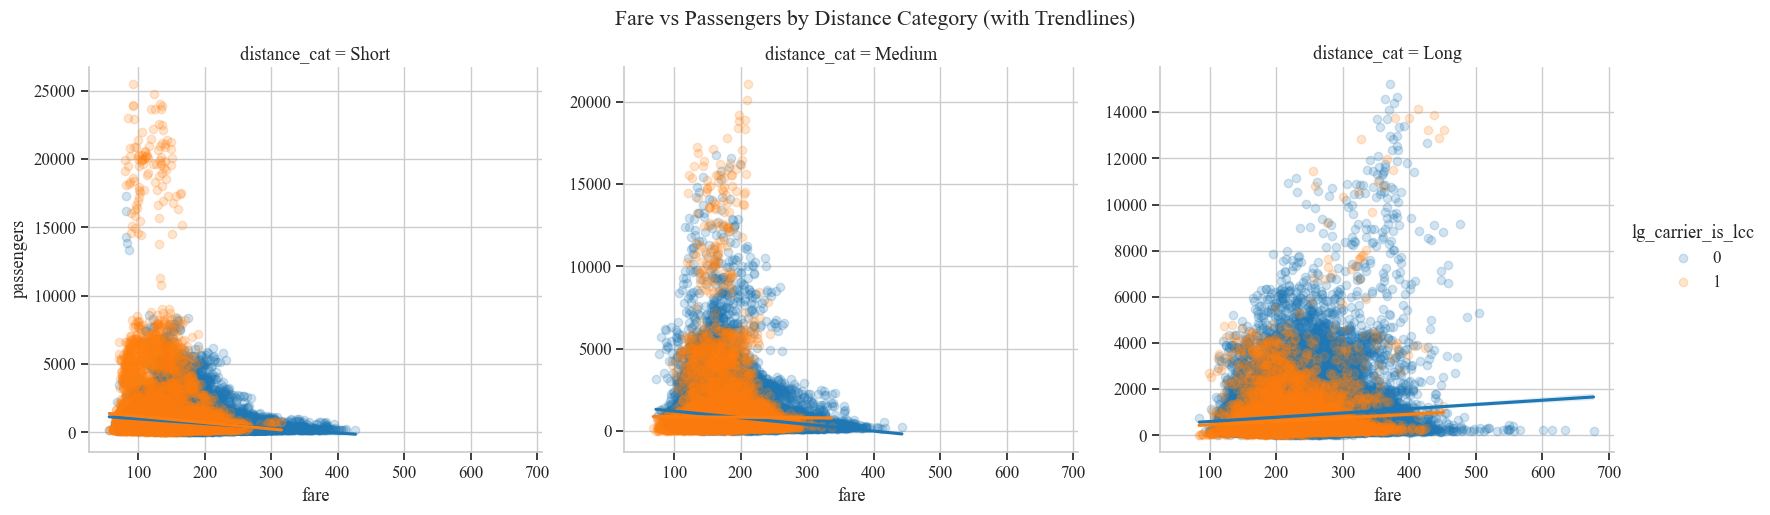

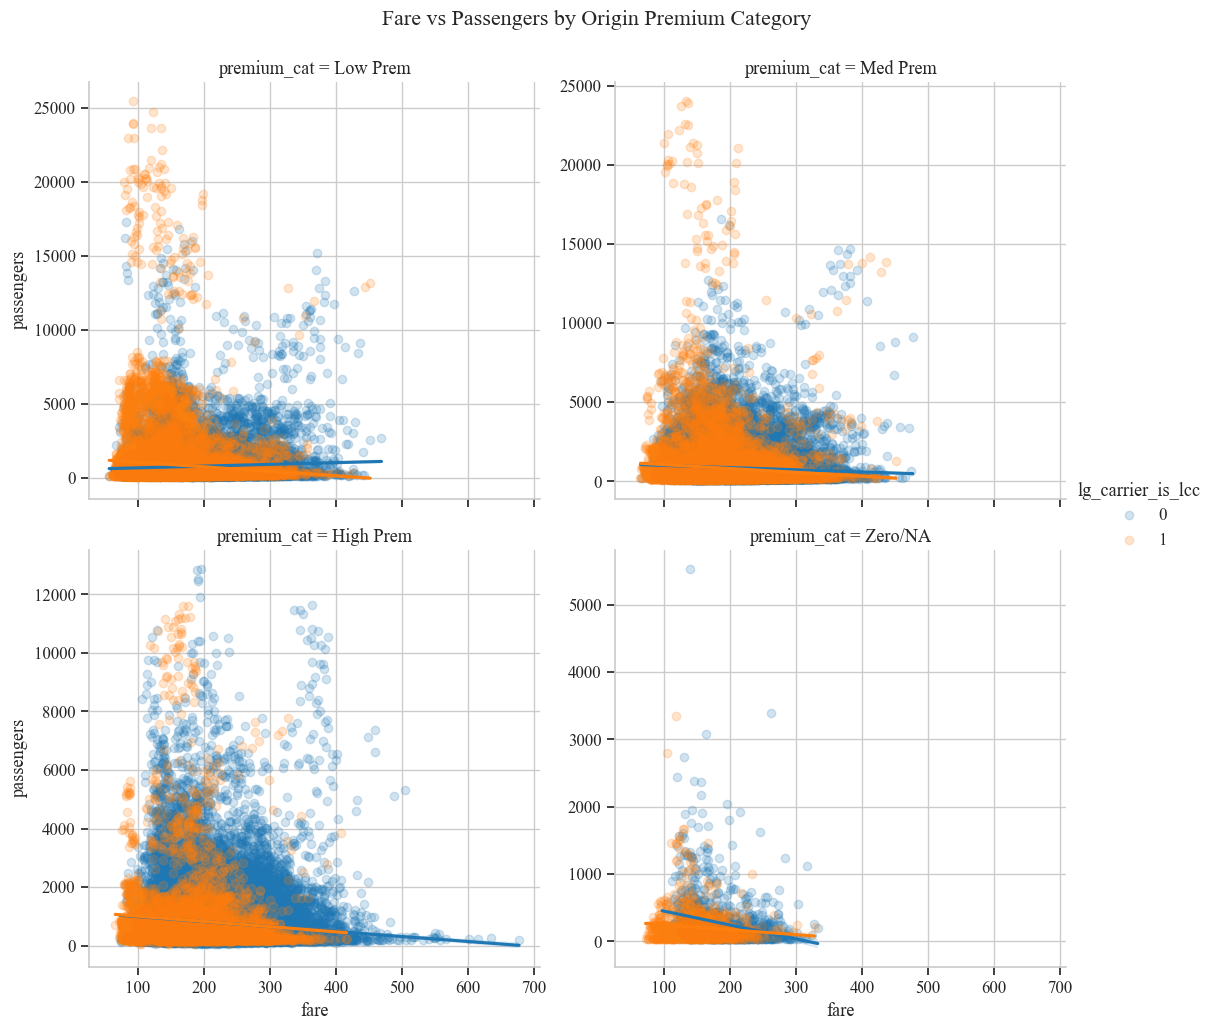

In [17]:
# Explore if T->Y relationship varies across levels of a third variable (W or X)
# Fare/Passenger relationship by Distance category
hue_col = 'lg_carrier_is_lcc' if 'lg_carrier_is_lcc' in df.columns else None

if not pd.api.types.is_numeric_dtype(df['nsmiles']):
    df.nsmiles = pd.to_numeric(df['nsmiles'], errors='coerce')
    
df['distance_cat'] = pd.qcut(df['nsmiles'].dropna(), q=3, labels=['Short', 'Medium', 'Long'], duplicates='drop')
g = sns.lmplot(data=df.dropna(subset=['distance_cat', 'fare', 'passengers']), 
                x='fare', y='passengers', col='distance_cat', hue=hue_col,
                scatter_kws={'alpha':0.2}, height=5, aspect=1.1, 
                facet_kws={'sharey': False}) # pass sharey via facet_kws
g.fig.suptitle('Fare vs Passengers by Distance Category (with Trendlines)', y=1.03)
plt.savefig(f'../outputs/EDA_reg_fare-pax_by_distance.png', dpi=400)
plt.show()


# Fare/Passenger relationship by Origin Premium category
# Create categories, handle 0 carefully if fillna(0) was used
prem_nonzero = df.loc[df['origin_fare_premium'] != 0, 'origin_fare_premium']

df['premium_cat'] = pd.qcut(prem_nonzero.dropna(), q=3, labels=['Low Prem', 'Med Prem', 'High Prem'], duplicates='drop')
df['premium_cat'] = df['premium_cat'].cat.add_categories(['Zero/NA']).fillna('Zero/NA') # assign category for 0/NaN

g = sns.lmplot(data=df.dropna(subset=['premium_cat', 'fare', 'passengers']), 
                x='fare', y='passengers', col='premium_cat', col_wrap=2, hue=hue_col,
                scatter_kws={'alpha':0.2}, height=5, aspect=1.1, 
                facet_kws={'sharey': False})
g.fig.suptitle('Fare vs Passengers by Origin Premium Category', y=1.03)
plt.savefig(f'../outputs/EDA_reg_fare-pax_by_origin-premium.png', dpi=400)
plt.show()

## **Section 9 - Pairplot**


--- Section 8: Pairplot Analysis ---
Generating Pairplot...


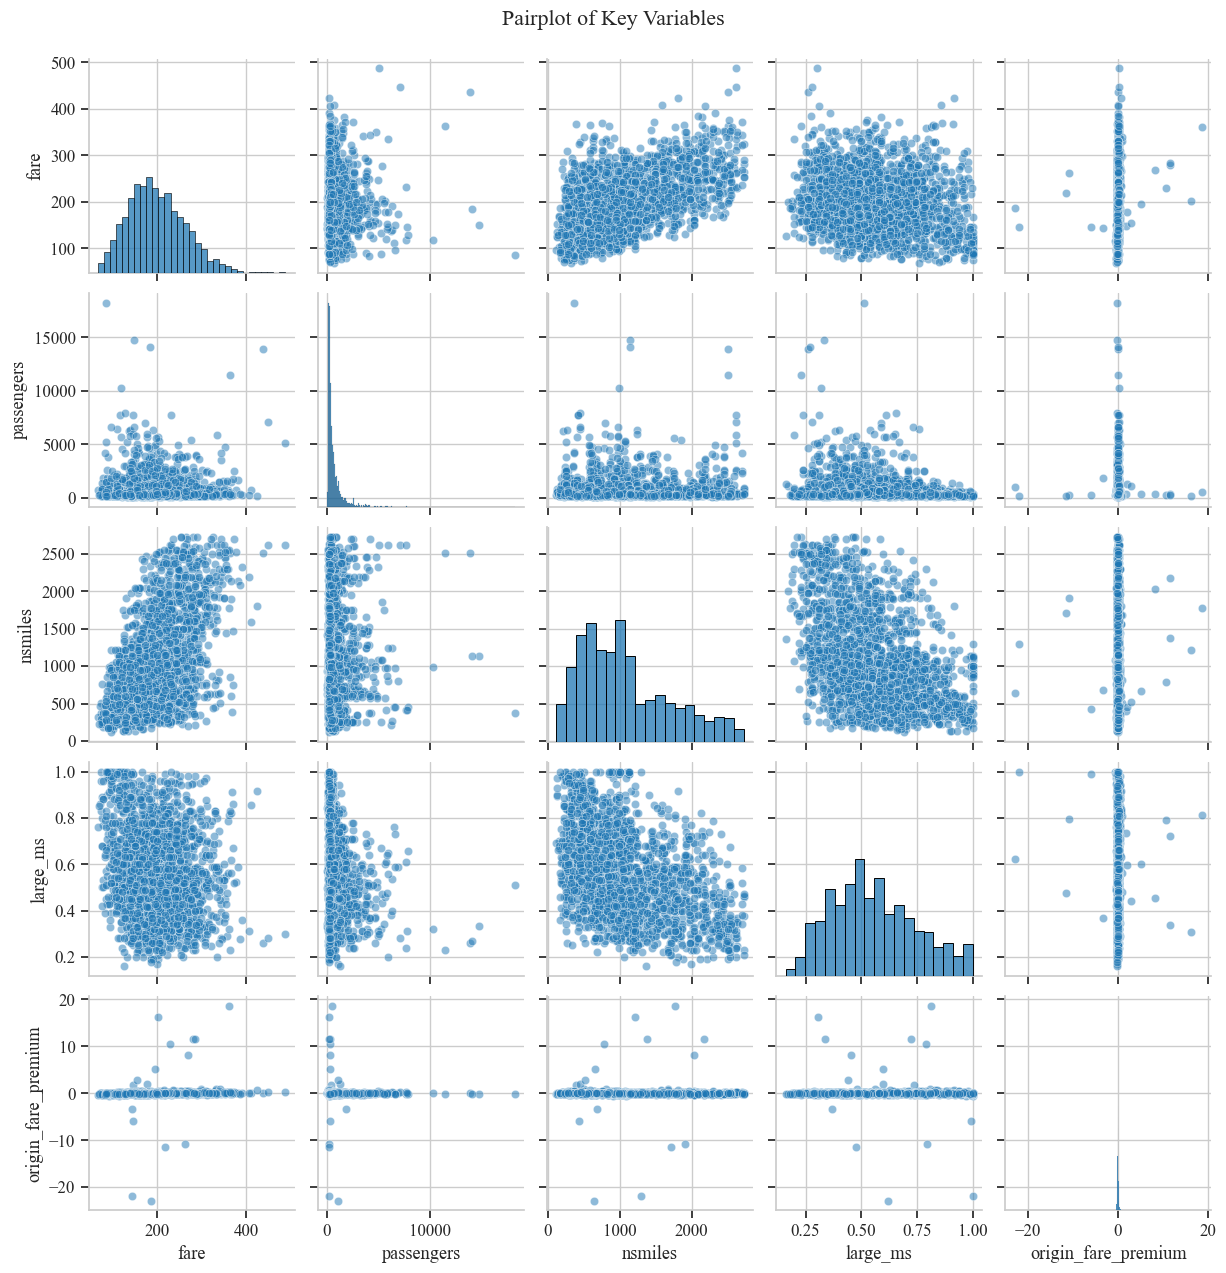

In [18]:
print("\n--- Section 8: Pairplot Analysis ---")
pairplot_vars = ['fare', 'passengers', 'nsmiles', 'large_ms', 'origin_fare_premium']
pairplot_vars = [col for col in pairplot_vars if col in df.columns]
print("Generating Pairplot...")
sample_frac = 2000 / len(df) if len(df) > 2000 else 1.0
sample_df = df.sample(frac=min(sample_frac, 1.0), random_state=42) # ensure frac <= 1
sns.pairplot(sample_df[pairplot_vars], diag_kind='hist', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.show()


## **Section 10 - Price Sensitivity Analysis (Table 3 & 4)**

Analyzing Demand Response to Significant Fare Changes (Tables 3 & 4)

In [19]:
df3 = pd.read_csv('../datasets/processed/df3.csv', sep=',')
df4 = pd.read_csv('../datasets/processed/df4.csv', sep=',')
print("Data loaded successfully!")
print(df3.info())
print(df4.info())

Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                3052 non-null   object 
 1   quarter             3052 non-null   int64  
 2   citymarketid_1      3052 non-null   object 
 3   citymarketid_2      3052 non-null   object 
 4   city1               3052 non-null   object 
 5   city2               3052 non-null   object 
 6   cur_passengers      3052 non-null   int64  
 7   cur_fare            3052 non-null   float64
 8   ly_fare             3052 non-null   float64
 9   ly_passengers       3052 non-null   int64  
 10  amount_change       3052 non-null   float64
 11  percent_change      3052 non-null   float64
 12  amount_change_pax   3052 non-null   int64  
 13  percent_change_pax  3052 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 333.9+ KB
None
<class 'pandas

In [20]:
fare_change = 'percent_change'
pax_change = 'percent_change_pax'

In [21]:
df3['change_type'] = 'Increase'
df4['change_type'] = 'Decrease'

dfx_changes = pd.concat([df3, df4], ignore_index=True)
dfx_changes.dropna(subset=[fare_change, pax_change], inplace=True)
dfx_changes.shape

(6041, 15)


Plotting significant fare change vs. passenger change...


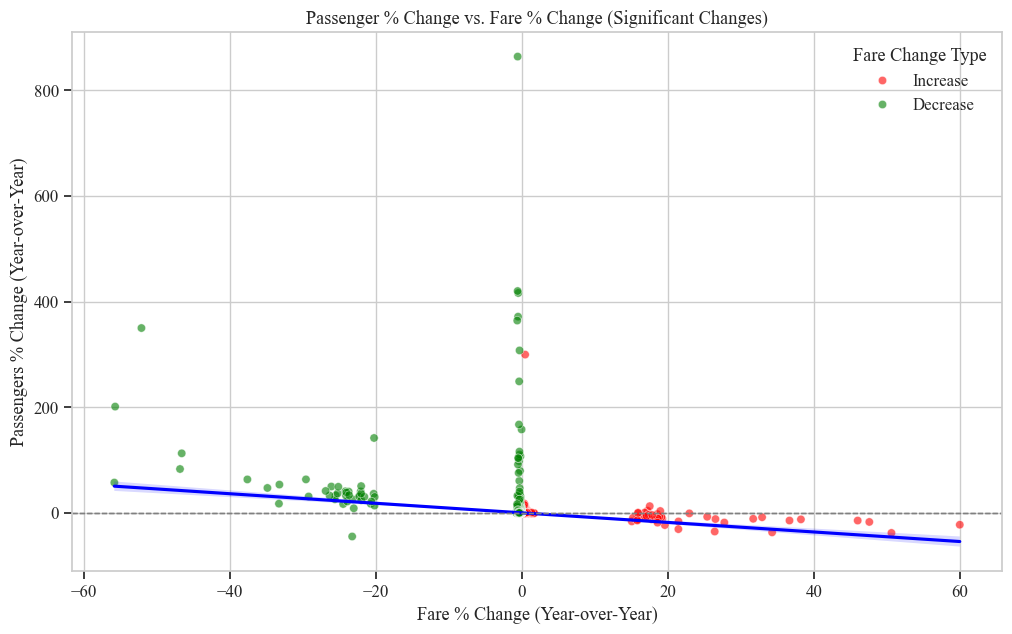

In [22]:
print("\nPlotting significant fare change vs. passenger change...")

plt.figure(figsize=(12, 7))

sns.scatterplot(data=dfx_changes, x=fare_change, y=pax_change, 
                hue='change_type', alpha=0.6, palette={'Increase': 'red', 'Decrease': 'green'})

sns.regplot(data=dfx_changes, x=fare_change, y=pax_change, 
            scatter=False, color='blue', robust=True, line_kws={'label': 'Overall Trend (Robust Fit)'})

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Passenger % Change vs. Fare % Change (Significant Changes)")
plt.xlabel("Fare % Change (Year-over-Year)")
plt.ylabel("Passengers % Change (Year-over-Year)")
plt.legend(title='Fare Change Type')
plt.grid(True)
plt.savefig('../outputs/EDA_price_sensitivity.png', dpi=300)
plt.show()

In [23]:
dfx_changes['Year'] = dfx_changes['Year'].astype(str)
dfx_changes['Year'] = dfx_changes['Year'].str.replace(',', '', regex=False)

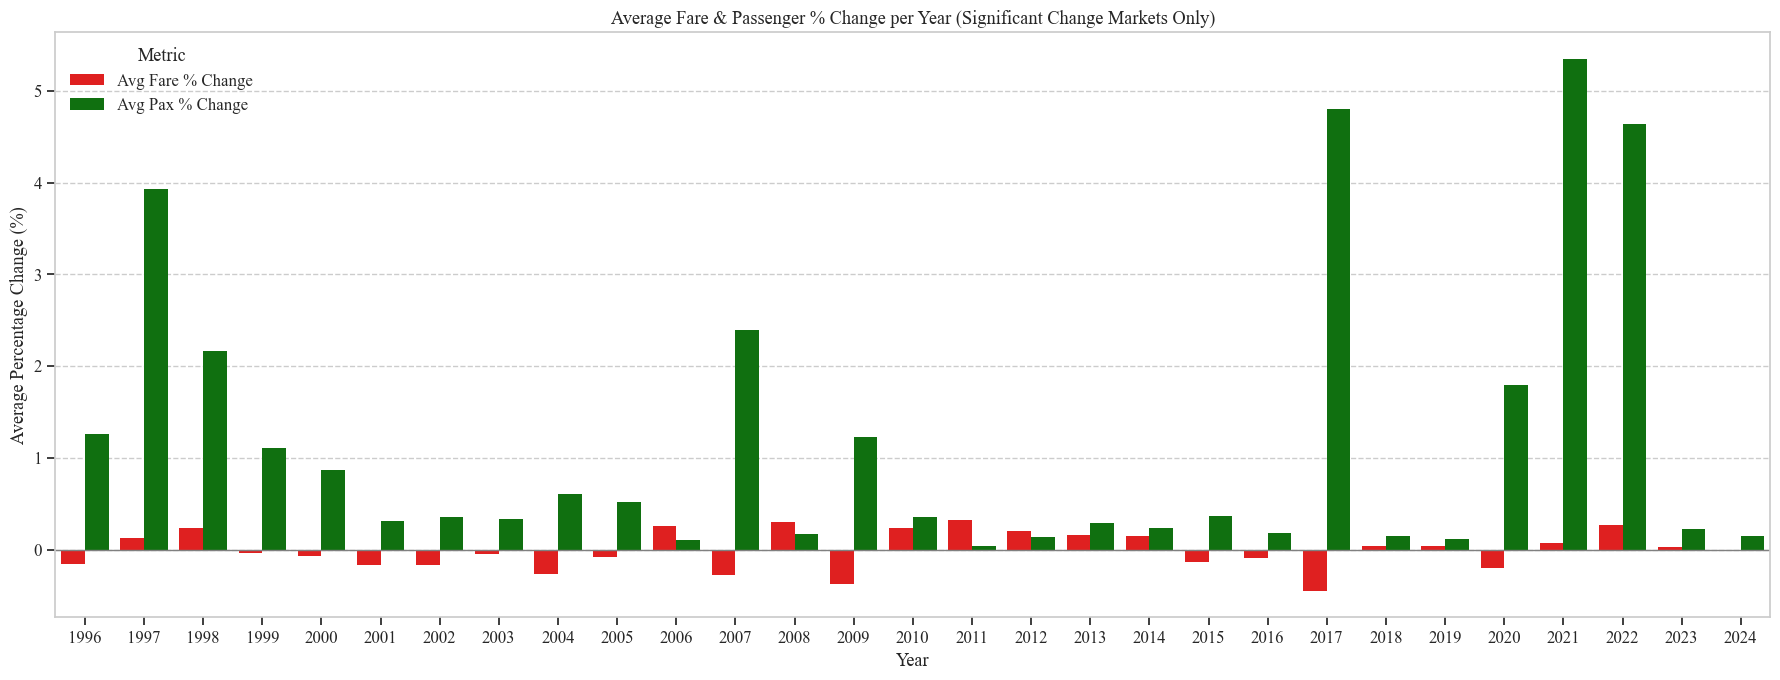

In [24]:
dfx_changes[fare_change] = pd.to_numeric(dfx_changes[fare_change], errors='coerce')
dfx_changes[pax_change] = pd.to_numeric(dfx_changes[pax_change], errors='coerce')

dfx_changes_agg = dfx_changes.dropna(subset=[fare_change, pax_change, 'Year']) 

avg_period_changes = dfx_changes_agg.groupby('Year')[[fare_change, pax_change]].mean().reset_index()
avg_period_changes.rename(columns={fare_change: 'Avg Fare % Change',
                                   pax_change: 'Avg Pax % Change'}, inplace=True)

avg_period_changes = avg_period_changes.sort_values('Year')

# --- Prepare data for Seaborn's grouped barplot ---
# Melt the dataframe to have 'Year', 'Metric', 'Average % Change' columns
df_melt = pd.melt(avg_period_changes,
                  id_vars=['Year'],
                  value_vars=['Avg Fare % Change', 'Avg Pax % Change'],
                  var_name='Metric',
                  value_name='Average % Change')

plt.figure(figsize=(18, 7)) # Wider plot

ax = sns.barplot(data=df_melt, x='Year', y='Average % Change', hue='Metric',
                     palette={'Avg Fare % Change': 'red', 'Avg Pax % Change': 'green'})

plt.title('Average Fare & Passenger % Change per Year (Significant Change Markets Only)')
plt.xlabel('Year')
plt.ylabel('Average Percentage Change (%)')
plt.axhline(0, color='grey', linestyle='-', lw=1)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('../outputs/EDA_avg_change_per_year.png', dpi=300)
plt.show()

## **Section 11 - Feature Engineering**

Using Log-Transformed + StandardScaler

In [25]:
skewed_cols = ['passengers', 'fare']
for col in skewed_cols:
    df[f'log_{col}'] = np.log1p(df[col].astype(float))
    print(f"Created log-transformed column: 'log_{col}'")

Created log-transformed column: 'log_passengers'
Created log-transformed column: 'log_fare'


In [26]:
# Target for Prediction Model
TARGET_PREDICTION = 'log_passengers'

# Features for Prediction Model (X_pred) - include treatment and potential confounders/predictors
FEATURES_PREDICTION = [
    'log_fare', # include treatment variable as a predictor
    'nsmiles',
    'large_ms',
    'lf_ms',
    'origin_fare_premium',
    'origin_perc_lcc_pax',
    'dest_fare_premium',
    'dest_perc_lcc_pax',
    'Year', # keep as numeric trend 
    'quarter', # keep as numeric 
    'lg_carrier_is_lcc', # binary
    'carrier_lg',
    'Q_2', 'Q_3', 'Q_4',
    'is_Q_with_NYD', 
    'is_Q_with_Memorial', 
    'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 
    'is_Q_with_Thx', 
    'is_Q_with_Christmas', 
    'is_Q_with_Any_Holiday',
    'avg_fuel_price'
]

# --- Variables for Causal Model ---
# Outcome (Y)
OUTCOME_CAUSAL = 'log_passengers'
# Treatment (T) - the variable whose effect we want to estimate
TREATMENT_CAUSAL = 'fare'
# Confounders (W) - variables affecting BOTH treatment and outcome
# Exclude the outcome itself!
CONFOUNDERS_CAUSAL = [
    'log_fare',
    'nsmiles',
    'large_ms',
    'lf_ms',
    'origin_fare_premium',
    'origin_perc_lcc_pax',
    'dest_fare_premium',
    'dest_perc_lcc_pax',
    'Year', # control for time trends
    'quarter', # control for seasonality
    'lg_carrier_is_lcc',
    'carrier_lg',
    'is_Q_with_NYD', 
    'is_Q_with_Memorial', 
    'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 
    'is_Q_with_Thx', 
    'is_Q_with_Christmas', 
    'is_Q_with_Any_Holiday',
    'carrier_lg',
    'avg_fuel_price' # control for fuel cost impact on fare/passengers
    # City-pair fixed effects might be too high-dimensional unless using specific models
]

# Features for Heterogeneity (X_het) - variables across which the treatment effect might vary
# Often a subset of W, or specific interaction candidates
FEATURES_HETEROGENEITY = [
    'nsmiles', # effect might differ by distance
    'large_ms', # effect might differ by market concentration
    'lg_carrier_is_lcc', # effect might differ for LCCs vs Legacy
    'origin_fare_premium', # effect might differ in high/low premium cities
    'distance_cat', 
    'premium_cat',
    'is_Q_with_NYD', 
    'is_Q_with_Memorial', 
    'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 
    'is_Q_with_Thx', 
    'is_Q_with_Christmas', 
    'is_Q_with_Any_Holiday',
    'quarter',
    'avg_fuel_price'
]

# Keep only columns that actually exist in the dataframe 'df'
features_prediction = [f for f in FEATURES_PREDICTION if f in df.columns]
confounders_causal = [f for f in CONFOUNDERS_CAUSAL if f in df.columns]
features_heterogeneity = [f for f in FEATURES_HETEROGENEITY if f in df.columns]

print(f"Target for Prediction: {TARGET_PREDICTION}")
print(f"Features for Prediction: {features_prediction}")
print(f"\nOutcome for Causal: {OUTCOME_CAUSAL}")
print(f"Treatment for Causal: {TREATMENT_CAUSAL}")
print(f"Confounders for Causal: {confounders_causal}")
print(f"Features for Heterogeneity: {features_heterogeneity}")


Target for Prediction: log_passengers
Features for Prediction: ['log_fare', 'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'quarter', 'lg_carrier_is_lcc', 'carrier_lg', 'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday', 'avg_fuel_price']

Outcome for Causal: log_passengers
Treatment for Causal: fare
Confounders for Causal: ['log_fare', 'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'quarter', 'lg_carrier_is_lcc', 'carrier_lg', 'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas', 'is_Q_with_Any_Holiday', 'carrier_lg', 'avg_fuel_price']
Features for Heterogeneity: ['nsmiles', 'large_ms', 'lg_carrier_is_lcc', 'origin_fare_premium', 'distance_cat', 'premium_cat', 'is_Q

In [27]:
# --- Create Final DataFrame for Modeling ---
# Select all necessary columns
all_modeling_cols = list(set(
    [TARGET_PREDICTION, OUTCOME_CAUSAL, TREATMENT_CAUSAL] +
    features_prediction +
    confounders_causal +
    features_heterogeneity
))
all_modeling_cols.append('passengers') # need original 'passengers' for MAE/RMSE
df_model = df[all_modeling_cols].copy()

In [28]:
# --- Feature Transformations ---

# 1. Handle Categorical Features (Example: One-Hot Encoding for Quarter & Carrier)
# Decide if 'quarter' should be cyclic, dummy, or ordinal. Dummies are common.

print("\nApplying One-Hot Encoding for 'quarter'...")
df_model['quarter'] = df_model['quarter'].astype('category')
df_model = pd.get_dummies(df_model, columns=['quarter'], prefix='Q', drop_first=True) # drop_first=True avoids multicollinearity
print("Columns after adding quarter dummies:", df_model.columns.tolist())



Applying One-Hot Encoding for 'quarter'...
Columns after adding quarter dummies: ['is_Q_with_Christmas', 'is_Q_with_Thx', 'is_Q_with_Any_Holiday', 'log_fare', 'lf_ms', 'Year', 'log_passengers', 'origin_fare_premium', 'is_Q_with_NYD', 'avg_fuel_price', 'is_Q_with_Memorial', 'dest_perc_lcc_pax', 'carrier_lg', 'is_Q_with_Labor', 'is_Q_with_Jul4_Indep', 'fare', 'premium_cat', 'large_ms', 'nsmiles', 'dest_fare_premium', 'distance_cat', 'origin_perc_lcc_pax', 'lg_carrier_is_lcc', 'passengers', 'Q_2', 'Q_3', 'Q_4']


In [29]:
# One-Hot Encode carrier_lg
# One-hot encode 'carrier_lg' might create many columns if many carriers. Consider top N?
print("\nApplying One-Hot Encoding for 'carrier_lg' (top 3)...")
top_3_carriers = df_model['carrier_lg'].value_counts().nlargest(3).index.tolist()
top_3_dummy_carriers = []
for c in top_3_carriers:
    dummy_col_name = f'carrier_{c}'
    # 1 if carrier_lg matches this top carrier, otherwise 0
    df_model[dummy_col_name] = np.where(df_model['carrier_lg'] == c, 1, 0)
    top_3_dummy_carriers.append(dummy_col_name)
    print(f"Created dummy column {dummy_col_name}!")

df_model.drop('carrier_lg', axis=1, inplace=True) # drop original column
# Update feature lists if carrier dummies are added
features_prediction.append(top_3_dummy_carriers)
features_prediction.remove('carrier_lg') # if it was there
confounders_causal.append(top_3_dummy_carriers)
confounders_causal.remove('carrier_lg') # if it was there



Applying One-Hot Encoding for 'carrier_lg' (top 3)...
Created dummy column carrier_WN!
Created dummy column carrier_DL!
Created dummy column carrier_AA!


In [30]:
# 2. Create Interaction Terms (Optional Example)
# Based on EDA/Hypothesis, e.g., does fare effect depend on LCC presence?
print("\nCreating Interaction Term (fare * lg_carrier_is_lcc)...")
df_model['fare_x_is_lcc'] = df_model['fare'] * df_model['lg_carrier_is_lcc']


Creating Interaction Term (fare * lg_carrier_is_lcc)...


In [31]:
# 3. Scaling Numerical Features (Setup - actual scaling happens AFTER train/test split)
# Identify numerical features needing scaling (excluding binary/dummy vars)

numerical_features_to_scale = [
    'log_fare', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax',
    'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', #'fare_lg', 'fare_low'
]
    
# Filter based on columns present in df_model
numerical_features_to_scale = sorted(list(set([f for f in numerical_features_to_scale if f in df_model.columns])))

print(f"\nNumerical features identified for scaling (will be done after split): {numerical_features_to_scale}")

# 4. Final Check
print("\n--- Final Processed DataFrame for Modeling (df_model) ---")
df_model.info()
print(df_model.head())


Numerical features identified for scaling (will be done after split): ['Year', 'dest_fare_premium', 'dest_perc_lcc_pax', 'fare', 'large_ms', 'lf_ms', 'log_fare', 'nsmiles', 'origin_fare_premium', 'origin_perc_lcc_pax']

--- Final Processed DataFrame for Modeling (df_model) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   is_Q_with_Christmas    115032 non-null  int64   
 1   is_Q_with_Thx          115032 non-null  int64   
 2   is_Q_with_Any_Holiday  115032 non-null  int64   
 3   log_fare               115032 non-null  float64 
 4   lf_ms                  115032 non-null  float64 
 5   Year                   115032 non-null  Int64   
 6   log_passengers         115032 non-null  float64 
 7   origin_fare_premium    115032 non-null  float64 
 8   is_Q_with_NYD          115032 non-null  int64   
 9   avg_fuel_pr

In [32]:
# --- Save Processed Data ---
fpath_processed = '../datasets/processed/final_df.csv'
df_model.to_csv(fpath_processed, index=False)
print(f"Processed data saved to {fpath_processed}!")

Processed data saved to ../datasets/processed/final_df.csv!


## **Addition Data Insights**

Calculating and plotting % changes (requires time series data per route)...


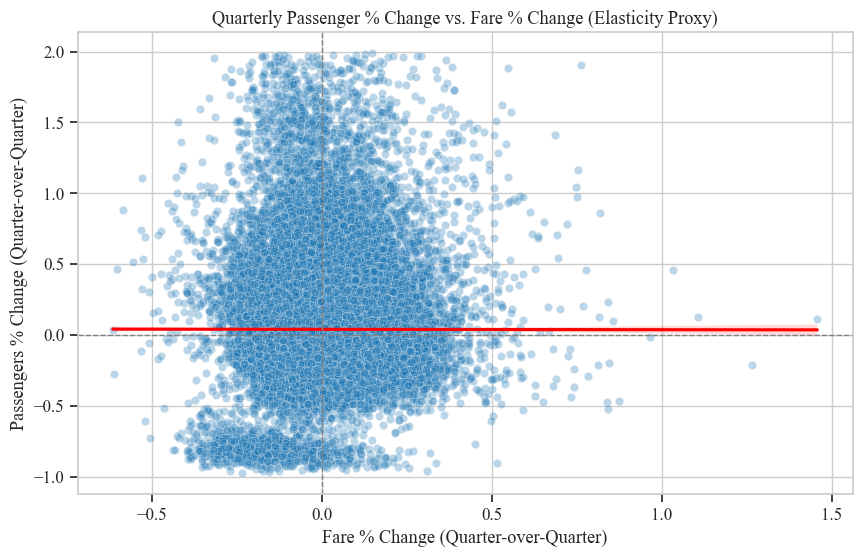

In [33]:
# --- Effect of Fare Change % on Passenger Change % ---
print("Calculating and plotting % changes (requires time series data per route)...")
df = df.sort_values(by=['route_id', 'Year', 'quarter'])
# Calculate lagged values within each route
df['fare_lag1'] = df.groupby('route_id')['fare'].shift(1)
df['passengers_lag1'] = df.groupby('route_id')['passengers'].shift(1)
# Calculate percentage change
df['fare_pct_change'] = (df['fare'] - df['fare_lag1']) / df['fare_lag1']
df['passengers_pct_change'] = (df['passengers'] - df['passengers_lag1']) / df['passengers_lag1']

# Filter out infinite or NaN values and extreme outliers for plotting
plot_df_change = df[['fare_pct_change', 'passengers_pct_change']].replace([np.inf, -np.inf], np.nan).dropna()

# Clip extreme values for better visualization (e.g., changes > 200% or < -100%)
plot_df_change = plot_df_change[
    (plot_df_change['fare_pct_change'] < 2) & (plot_df_change['fare_pct_change'] > -1) &
    (plot_df_change['passengers_pct_change'] < 2) & (plot_df_change['passengers_pct_change'] > -1)
]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df_change, x='fare_pct_change', y='passengers_pct_change', alpha=0.3)
# Add a regression line to estimate average elasticity visually
sns.regplot(data=plot_df_change, x='fare_pct_change', y='passengers_pct_change', scatter=False, color='red')
plt.title('Quarterly Passenger % Change vs. Fare % Change (Elasticity Proxy)')
plt.xlabel('Fare % Change (Quarter-over-Quarter)')
plt.ylabel('Passengers % Change (Quarter-over-Quarter)')
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(0, color='grey', linestyle='--', lw=1)
plt.grid(True)
plt.show()

# The slope of the regression line gives a rough estimate of price elasticity of demand.


Plotting trends by carrier type...


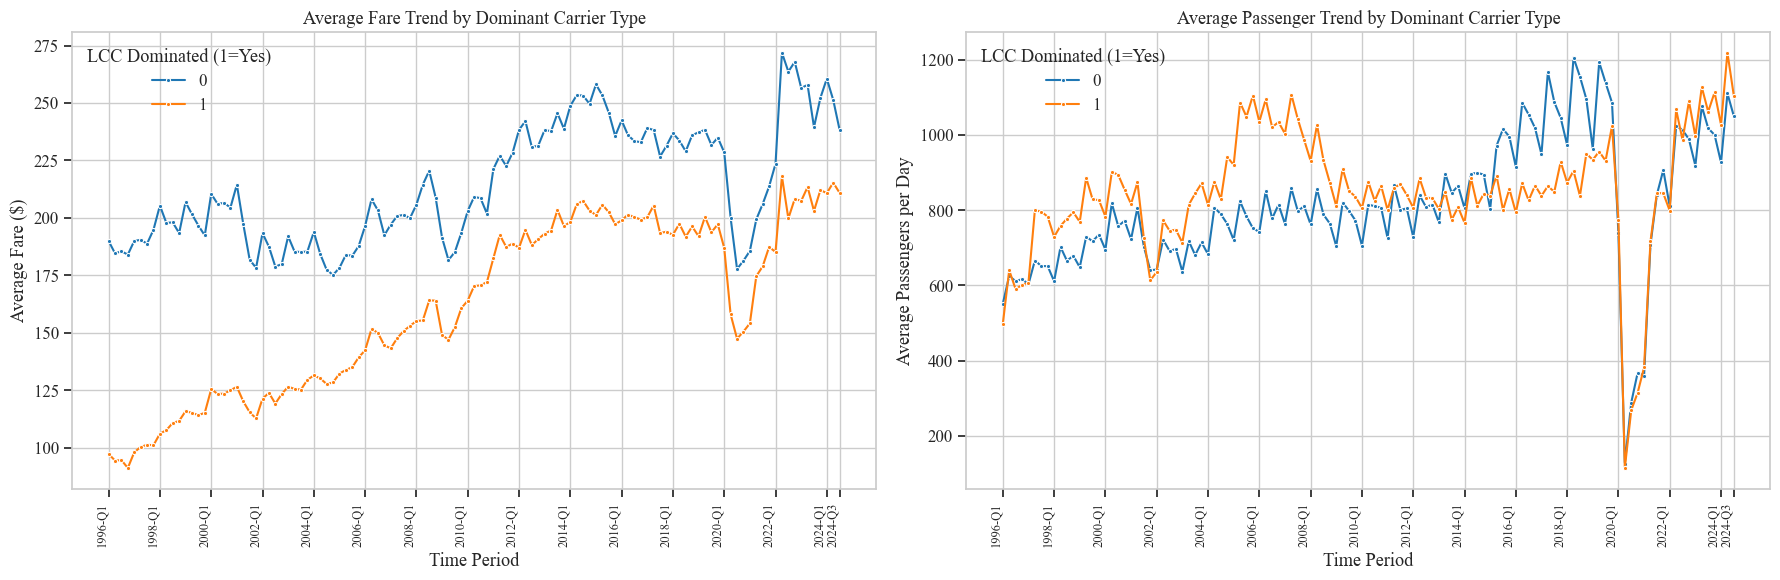

In [34]:
# --- Trends in Low-cost vs Legacy Carriers ---
print("Plotting trends by carrier type...")

# Aggregate data by period and carrier type indicator
if 'lg_carrier_is_lcc' in df.columns and 'period' in df.columns:
    try:
        numeric_cols = ['fare', 'passengers']
        numeric_cols = [c for c in numeric_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
        if not numeric_cols:
             print("Skipping plot: No numeric columns ('fare', 'passengers') found or numeric.")
        else:
            df_agg_carrier = df.groupby(['period', 'lg_carrier_is_lcc'])[numeric_cols].mean().reset_index()
            df_agg_carrier = df_agg_carrier.sort_values('period') # sort by period string

            # --- Create subplots ---
            fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

            # --- Plot 1: Fare Trends ---
            sns.lineplot(data=df_agg_carrier, x='period', y='fare', hue='lg_carrier_is_lcc', marker='.', ax=axes[0])
            axes[0].set_title('Average Fare Trend by Dominant Carrier Type')
            axes[0].set_xlabel('Time Period') 
            axes[0].set_ylabel('Average Fare ($)')
            axes[0].legend(title='LCC Dominated (1=Yes)')
            axes[0].grid(True)

            # --- Plot 2: Passenger Trends ---
            sns.lineplot(data=df_agg_carrier, x='period', y='passengers', hue='lg_carrier_is_lcc', marker='.', ax=axes[1])
            axes[1].set_title('Average Passenger Trend by Dominant Carrier Type')
            axes[1].set_xlabel('Time Period') 
            axes[1].set_ylabel('Average Passengers per Day')
            axes[1].legend(title='LCC Dominated (1=Yes)')
            axes[1].grid(True)

            # 1. Get unique sorted period labels from the aggregated data
            all_periods = df_agg_carrier['period'].unique().tolist()
            num_periods = len(all_periods)

            # 2. Determine tick frequency (e.g., every 8 quarters = 2 years)
            tick_step = 8 
            if num_periods / tick_step > 15: # heuristic: If still > 15 labels, increase step
                tick_step = 12 # every 3 years
            elif num_periods / tick_step > 10:
                 tick_step = 8 # stick to 2 years if between 10-15 labels

            # Create indices (positions) and corresponding labels for the ticks
            tick_indices = np.arange(0, num_periods, tick_step)
            # Ensure the last period is included if it's close to the end
            if num_periods > 0 and num_periods - 1 not in tick_indices and tick_indices.size > 0 and num_periods - 1 - tick_indices[-1] < tick_step / 2:
                 tick_indices = np.append(tick_indices, num_periods - 1)
            # Ensure indices are within bounds
            tick_indices = tick_indices[tick_indices < num_periods]
            tick_labels = [all_periods[i] for i in tick_indices]

            # 3. Apply sparse ticks and labels to BOTH axes
            for ax in axes:
                ax.set_xticks(tick_indices) 
                ax.set_xticklabels(tick_labels, rotation=90, ha='right', fontsize=9) 

            plt.tight_layout() 
            plt.savefig(f'../outputs/EDA_fare_pax_trend_by_LCC.png', dpi=300)
            plt.show()

    except Exception as e:
         print(f"An error occurred during plotting: {e}")
else:
     print("Skipping plot: Required columns ('period', 'lg_carrier_is_lcc') not found.")

Clustering routes by demand level...

Demand Cluster Centers (Average Passengers):
0      364.675917
1     3322.162913
2    12055.266087
dtype: float64


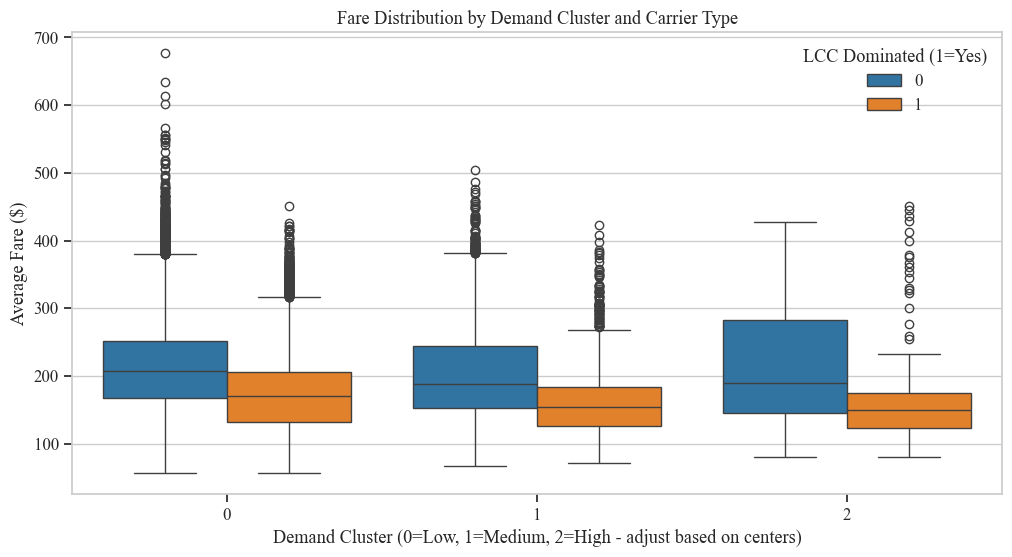

In [35]:
# --- High-demand vs Low-demand Route Clusters ---
print("Clustering routes by demand level...")
# Use average demand per route for clustering
route_avg_demand = df.groupby('route_id')['passengers'].mean().reset_index()

# Use KMeans to create clusters (e.g., 3 clusters: Low, Medium, High)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
route_avg_demand['demand_cluster'] = kmeans.fit_predict(route_avg_demand[['passengers']])

# Map cluster labels back to the main dataframe
df = pd.merge(df, route_avg_demand[['route_id', 'demand_cluster']], on='route_id', how='left')

# Visualize characteristics of clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='demand_cluster', y='fare', hue='lg_carrier_is_lcc')
plt.title('Fare Distribution by Demand Cluster and Carrier Type')
plt.xlabel('Demand Cluster (0=Low, 1=Medium, 2=High - adjust based on centers)')
plt.ylabel('Average Fare ($)')
plt.legend(title='LCC Dominated (1=Yes)')
# Print cluster centers to understand labeling
print("\nDemand Cluster Centers (Average Passengers):")
print(pd.Series(kmeans.cluster_centers_.flatten()).sort_values())
plt.show()